# Предсказание конечной температуры стали на производстве  
##  **Описание проекта**  
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.  
  
### Описание этапа обработки  
  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его 
облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## **План проекта**  
Опишем основные этапы проекта:  
1) Изучение данных  
    - Загружу все дата-сеты, изучу их содержимое  
    - Проверю наличие пропусков, ошибок, особенностей  
    - Выделю целевой признак и объект  
    - Проверю тип распределения данных  
      
2) Исследовательский анализ данных  
    В каждом датафрейме:  
    - Изучу распределение признаков  
    - Опеределю наличие выбросов и удалю их  
    - Изучу взаимосвязи между признаками  
    - Напишу общий вывод, опишу найденные особенности. Составлю список вопросов заказчику и предложений по устранению ошибок в данных  
      
3) Предобработка данных    
    - Объединю датафреймы в один в соответствии с объектом исследования  
    - Проверю получившийся датафрейм на пропуски, заполню или удалю их  
      
4) Подготовка данных к построению модели  
    - Определю тип задачи и выберу модели, которые буду использовать  
    - Выберу наиболее подходящюю метрику  
    - Создам обучающую и тестовые выборки  
    - Проверю необходимость стандартизации признаков  
      
5) Построение модели   
    - Для каждой модели с помощью GridsearchCV подберу оптимальные гиперпараметры  
    - Обучу каждую модель с оптимальными гиперпарамтрами  
    - выберу модель с лучшим показателем метрики  
      
6) Проверка модели на адекватность  
    - Проверю работу лучшей модели на тестовой выборке и сравню с требованием по качеству
    - Проведу исследование важности признаков(shap)  
      
7) Выводы  
Напишу общий вывод, содержащий :  
    1) ответы на вопросы:  
            - Какие пункты плана были выполнены, а какие нет и почему  
            - Какие трудности возникли и как их преодолел  
            - Какие ключевые шаги в решении задачи выделил  
            - Какая модель итоговая и какое у нее качество  
    2) Список признаков, используемых для обучения лучшей модели и описание их предобработки  
    3) Гиперпараметры лучшей модели, включая random_state  
    4) Рекомендации по улучшению модели.
     

## **Импорт бибилиотек**
Импортируем библиотеки, и добавляем по мере необходимости

In [68]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install shap
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

import shap

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## **Загрузка и изучение данных**  
Для начала загрузим все датасеты и изучим каждый из них в отдельности


In [69]:
data_arc = pd.read_csv("/datasets/data_arc_new.csv")# — данные об электродах;
data_bulk = pd.read_csv("/datasets/data_bulk_new.csv")# — данные о подаче сыпучих материалов (объём);
data_bulk_time = pd.read_csv("/datasets/data_bulk_time_new.csv")# — данные о подаче сыпучих материалов (время);
data_gas = pd.read_csv("/datasets/data_gas_new.csv") # — данные о продувке сплава газом;
data_temp = pd.read_csv("/datasets/data_temp_new.csv")# — результаты измерения температуры;
data_wire = pd.read_csv("/datasets/data_wire_new.csv")# — данные о проволочных материалах (объём);
data_wire_time = pd.read_csv("/datasets/data_wire_time_new.csv")# — данные о проволочных материалах (время).

### Изучение данных об электродах

In [70]:
data_arc.info()
data_arc.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Мы видим относительно небольшой датасет без пропусков. Ключевые признаки для нас находятся в колонках мощность key. Что такое Реактивная мощность и как она физически связана с Активной не известно - лучше уточнить у заказчика или найти самостоятельно. Тем не менее посмотрим на средние значения этих двух признаков.

In [71]:
display("Медиана мощностей", data_arc.median())
display("Средние мощности", data_arc.mean())

'Медиана мощностей'

key                    1617.000000
Активная мощность         0.599587
Реактивная мощность       0.441639
dtype: float64

'Средние мощности'

key                    1615.220422
Активная мощность         0.662752
Реактивная мощность       0.438986
dtype: float64

т.к. Активная и реактивная мощности являются составляющими общей потребляемой мощности, а средние значения как реактивной так и активной мощности очень схожи, то объединять их мы не будем и используем как отдельные признаки.  
  
У нас есть данные по началу и концу нагрева. Можно использовать эти данны, но текстовые значения при построении модели нам не подходят, поэтмоу расчитаем продолжительность нагрева.

In [72]:
#Переводим строки в даты.
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'],format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

#Считаем продолжительность нагрева в секундах.
data_arc['arc_time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])/ pd.Timedelta(seconds=1)

data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   arc_time              14876 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 697.4 KB


key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  arc_time  
0             0.211253     228.0  
1             0.477438     185.0  
2             0.430460     172.0  
3             0.379979     365.0  
4             0.643691     148.0

Теперь у нас есть время нагрева в секундах. Можно удалять лишние столбцы, и заодно посмотрим на количество уникальных партий key в этом датасете. предварительно проверив на полные дубликаты

In [73]:
display("количество полных дубликатов:", data_arc.duplicated().sum())
data_arc = data_arc.drop(['Начало нагрева дугой','Конец нагрева дугой'],axis = 1)
display("количество уникальных партий",len(data_arc['key'].unique()))
data_arc.head()

'количество полных дубликатов:'

0

'количество уникальных партий'

3214

key  Активная мощность  Реактивная мощность  arc_time
0    1           0.305130             0.211253     228.0
1    1           0.765658             0.477438     185.0
2    1           0.580313             0.430460     172.0
3    1           0.518496             0.379979     365.0
4    1           0.867133             0.643691     148.0

Полных дубликатов не оказалось, а уникальных партий всего 3214 из 14876 строк. Значит что каждая партия может проходить несколько этапов нагрева. Теперь перед объединением данных по партиям неплохо бы посмотреть на наличие аномалий в данных.

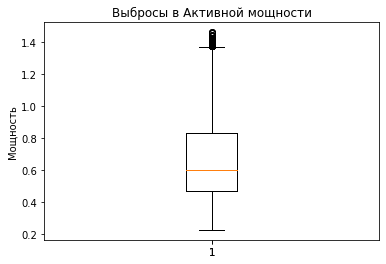

Выбросов в продажах:  72


In [74]:
boxplot = plt.boxplot(data_arc['Активная мощность'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_arc['Активная мощность'].values)
plt.ylabel('Мощность')
plt.title("Выбросы в Активной мощности")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

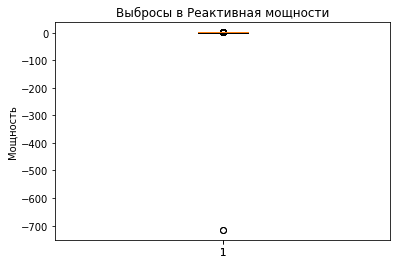

Выбросов в продажах:  199


In [75]:
boxplot = plt.boxplot(data_arc['Реактивная мощность'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_arc['Реактивная мощность'].values)
plt.ylabel('Мощность')
plt.title("Выбросы в Реактивная мощности")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

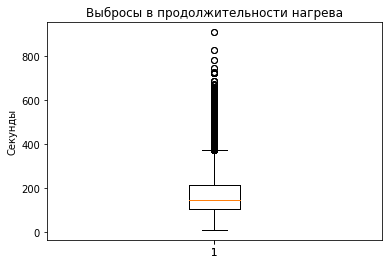

Выбросов в продолжительности нагрева:  617


In [76]:
boxplot = plt.boxplot(data_arc['arc_time'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_arc['arc_time'].values)
plt.ylabel('Секунды')
plt.title("Выбросы в продолжительности нагрева")
plt.show() 
print("Выбросов в продолжительности нагрева: ", len(outliers)) 

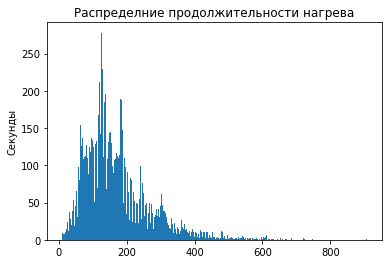

In [77]:
plt.hist(data_arc['arc_time'].values,bins=500)
plt.ylabel('Секунды')
plt.title("Распределние продолжительности нагрева")
plt.show() 

В продлжительности нагрева довольно много аномалий.Однако распределение выглядит нормальным, слегка смещенным вправо, и т.к у нас нет точных данных по технологическому процессу, то утверждать что мы вышли за допуски по времени мы не можем.Эту информацию уточним у заказчика, а пока удалять данные ничего не будем.  
  
А вот в Рекативной мощности явно присутствует Аномалия цифра -700 сильно выбивается. Удалим его и посмотрим на распределение еще раз    

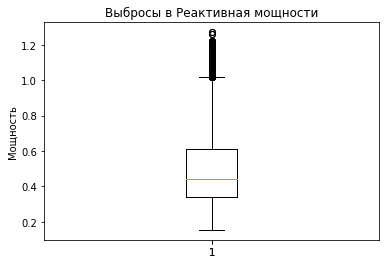

Выбросов в продажах:  198


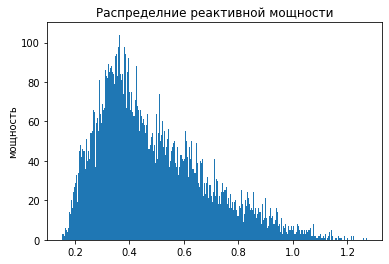

In [78]:
#Удаляем аномалию
anomaly = data_arc[data_arc['Реактивная мощность']<-600].index
data_arc=data_arc.drop(anomaly)

# Выводим диаграмму размаха
boxplot = plt.boxplot(data_arc['Реактивная мощность'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_arc['Реактивная мощность'].values)
plt.ylabel('Мощность')
plt.title("Выбросы в Реактивная мощности")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

# График распределения
plt.hist(data_arc['Реактивная мощность'].values,bins=500)
plt.ylabel('мощность')
plt.title("Распределние реактивной мощности")
plt.show() 

Распределине реактивной мощности так же нормальное, смещенное вправо, аномалий больше не наблюдается.  больше удалять ничего не будем.
  
Теперь посмотрим на распределение Активной мощности

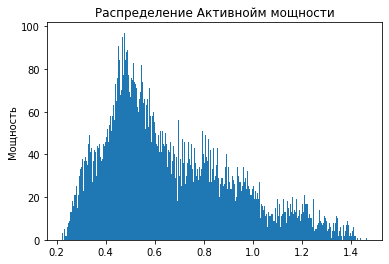

In [79]:
plt.hist(data_arc['Активная мощность'], bins=500)
plt.ylabel('Мощность')
plt.title('Распределение Активнойм мощности')
plt.show()

Так же как и с реактивной мощностью здесь наблюдается Нормальное, смещенное вправо распределение. Очевидных выбросов нет.
Под конец посмотрим на взаимосвязи между признаками

                          key  Активная мощность  Реактивная мощность  \
key                  1.000000          -0.010226            -0.013169   
Активная мощность   -0.010226           1.000000             0.966373   
Реактивная мощность -0.013169           0.966373             1.000000   
arc_time            -0.018341           0.010590             0.006661   

                     arc_time  
key                 -0.018341  
Активная мощность    0.010590  
Реактивная мощность  0.006661  
arc_time             1.000000  


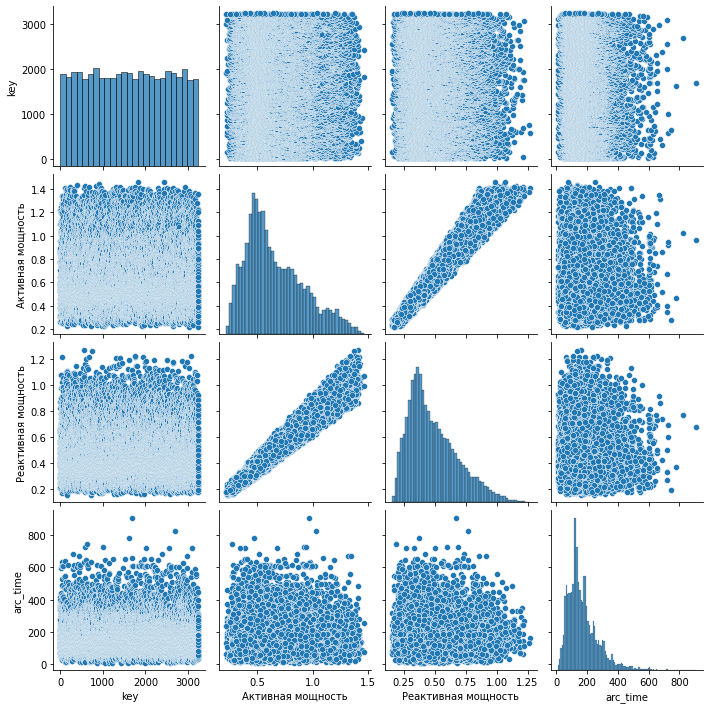

In [80]:
sns.pairplot(data_arc, diag_kind='hist')
print(data_arc.corr())

Сильная корреляция наблюдается только между активной и реактивной мощностями, что вполне логично, т.к. чем больше совокупная мощность тем больше и составные части.  

Продолжительность никак не коррелируется с потребляемыми мощностями, а значит данны по мощности могут быть указаны не за период указанный в данных, а за какой-то другой ( например за минуту работы или за час). этот вопрос нужно уточнить у заказчика.
  
Тем временем объединим все данные по нагреву в рамках одной партии.  

In [81]:
data_arc = data_arc.pivot_table(index='key', aggfunc='sum')
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   arc_time             3214 non-null   float64
 1   Активная мощность    3214 non-null   float64
 2   Реактивная мощность  3214 non-null   float64
dtypes: float64(3)
memory usage: 100.4 KB


arc_time  Активная мощность  Реактивная мощность
key                                                  
1      1098.0           3.036730             2.142821
2       811.0           2.139408             1.453357
3       655.0           4.063641             2.937457
4       741.0           2.706489             2.056992
5       869.0           2.252950             1.687991

#### Выводы и рекомендации.   
На основании проведенного исследования в данных по нагреву электродов мы имеем по три признака для каждой из 3214 партий товаров:
1) Активная мощность  
2) Реактивная мощность  
3) Продолжительность нагрева  
  
Признаки распределены нормально со смещением, аномалии удалены. Пропусков, дубликатов в данных нет.

Вопросы и рекомендации к заказчику :  
- Какие показатели мощности и продолжительности работы электродов укладываются в технологический регламент. Если иметь эти данные, то можно выяснить какие электроды и когда работают со сбоями, но это уже в рамках другой задачи.
- Можно ли складывать Активную и реактивную мощность в рамках задачи.
- Потребляемые мощности указаны совокупно за периоды указанные в датасете, или мощность указана например за 1 минуту, час и т.д.?

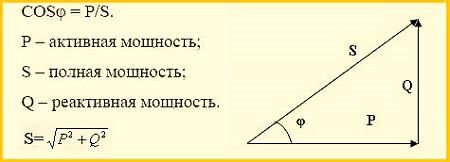

### Изучение данных о сыпучих материалах   
Эти данные хранятся в двух датасетакх : data_bulk data_bulk_time. Выведем информацию о них на экран

In [82]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [83]:
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Видно что, в этих датафреймах совпадают как колноки так и количество пропусков. Можно сделать вывод о том что время в одном датафрейме указано только при условии, что сыпучие материалы добавлялись. Но на всякий случай проверим это:  
переделаем наши датафреймы: если в есть пропуск -присваиваем значение 1, если нет - 0. Потом складываем два датафрейма по колонкам, и смотрим на уникальные значения. Если среди них будет только 2 и 0 , то значит, что так и есть - у каждой присадки с ненулевым значением есть время добавления, если есть хотя бы одна единица, значит где-то указано время но не указан объем добавления.

In [84]:
# переделываем датафрейм в 0 и 1
na_data_bulk = data_bulk.isnull()
na_data_bulk[na_data_bulk == True] = 1
na_data_bulk[na_data_bulk == False] = 0

na_data_bulk_time = data_bulk_time.isnull()
na_data_bulk_time[na_data_bulk_time == True] = 1
na_data_bulk_time[na_data_bulk_time == False] = 0
# Проверяем датафреймы на соответствие.
na_new = pd.DataFrame()
for i in na_data_bulk.columns:
    na_new[i] = na_data_bulk[i] + na_data_bulk_time[i]
    na_new[i] = na_new[i].astype(int)
    print(i,na_new[i].unique())


key [0]
Bulk 1 [2 0]
Bulk 2 [2 0]
Bulk 3 [2 0]
Bulk 4 [0 2]
Bulk 5 [2 0]
Bulk 6 [2 0]
Bulk 7 [2 0]
Bulk 8 [2 0]
Bulk 9 [2 0]
Bulk 10 [2 0]
Bulk 11 [2 0]
Bulk 12 [0 2]
Bulk 13 [2 0]
Bulk 14 [0 2]
Bulk 15 [0 2]


Как видно все впорядке. ошибок в данных нет - Везде где добавляли материалы указано и время добавления, соответственно если бы они были мы бы их удалили. Такое совпадение может говорить о том что данные действительно не содержат ошибок, а пропуски в таблице data_bulk можно заполнить нулями, т.к. пропуск в этих данных говорит о том что сыпучие материал попросту не добавляли.  
поскольку некоторые добавки использовались очень редко(некоторые всего один раз), то усложнять задачу ими не целесообразно, то объединим все добавки, которые использовались реже чем в 20% случаев в один признак "bulk_other", для нас это будут добавки 1,2,5,6,7,8,9,10,11,13., но предварительно нужно убедиться что данные по добавкам имеет соизмеримые значения.

In [85]:

display(data_bulk.mean(),data_bulk.median(),data_bulk.head(20))

key        1624.383509
Bulk 1       39.242063
Bulk 2      253.045455
Bulk 3      113.879045
Bulk 4      104.394477
Bulk 5      107.025974
Bulk 6      118.925347
Bulk 7      305.600000
Bulk 8       49.000000
Bulk 9       76.315789
Bulk 10      83.284091
Bulk 11      76.819209
Bulk 12     260.471020
Bulk 13     181.111111
Bulk 14     170.284747
Bulk 15     160.513345
dtype: float64

key        1622.0
Bulk 1       31.0
Bulk 2      251.5
Bulk 3       97.5
Bulk 4      102.0
Bulk 5       86.0
Bulk 6      100.0
Bulk 7      298.0
Bulk 8       49.0
Bulk 9       68.0
Bulk 10      86.5
Bulk 11      64.0
Bulk 12     208.0
Bulk 13     155.5
Bulk 14     151.0
Bulk 15     160.0
dtype: float64

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0     1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1     2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2     3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3     4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4     5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5     6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6     7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7     8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8     9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9    10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10   11     NaN     NaN     NaN    69.0     NaN     NaN     NaN     NaN   
11   12    46.0     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
12   13     NaN     NaN     NaN     NaN     NaN    72.0     NaN     NaN   
13   14     NaN     NaN    71.0     NaN     NaN     NaN     NaN     NaN   
14   15     NaN     NaN     NaN     NaN     NaN    77.0     NaN     NaN   
15   16     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
16   17     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
17   18     NaN     NaN     NaN     NaN     NaN    76.0     NaN     NaN   
18   19     NaN     NaN     NaN     NaN     NaN   219.0     NaN     NaN   
19   20     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0      NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1      NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2      NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3      NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4      NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5      NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6      NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7      NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8      NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9      NaN      NaN      NaN    203.0      NaN    102.0    204.0  
10     NaN      NaN      NaN    207.0      NaN    101.0    202.0  
11     NaN      NaN      NaN    618.0      NaN    406.0    203.0  
12     NaN      NaN      NaN    410.0      NaN    151.0    204.0  
13     NaN      NaN      NaN    204.0      NaN    152.0    203.0  
14     NaN      NaN      NaN      NaN      NaN    251.0    203.0  
15     NaN      NaN      NaN    206.0      NaN    100.0    203.0  
16     NaN      NaN      NaN      NaN      NaN    153.0    202.0  
17     NaN      NaN      NaN    206.0      NaN    103.0    203.0  
18     NaN      NaN      NaN      NaN      NaN      NaN      NaN  
19     NaN      NaN      NaN      NaN      NaN    249.0      NaN

Видно что значения признаков однородны, а их средняя и медиана также подтверждают необходимость объединения указанных выше добавок в одну группу, а так же добавим колонку с общим количеством всех добавок.

In [86]:
# заполняем пропуски нулями и складываем редкие добавки
data_bulk = data_bulk.fillna(0)
data_bulk['Bulk_other'] = (data_bulk['Bulk 1'] + data_bulk['Bulk 2'] + data_bulk['Bulk 5'] +
                           data_bulk['Bulk 6'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] + 
                           data_bulk['Bulk 9'] + data_bulk['Bulk 10'] + data_bulk['Bulk 11'] +
                           data_bulk['Bulk 13'])
data_bulk = data_bulk.drop(['Bulk 1','Bulk 2','Bulk 5','Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 13']
                           ,axis = 1)
                         
data_bulk.head()

key  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  Bulk_other
0    1     0.0    43.0    206.0    150.0    154.0         0.0
1    2     0.0    73.0    206.0    149.0    154.0         0.0
2    3     0.0    34.0    205.0    152.0    153.0         0.0
3    4     0.0    81.0    207.0    153.0    154.0         0.0
4    5     0.0    78.0    203.0    151.0    152.0         0.0

In [87]:
# добавляем колонку с общей суммой добавок.

data_bulk['Bulk_summ'] = (data_bulk['Bulk 3'] + data_bulk['Bulk 4'] + data_bulk['Bulk 12'] +
                           data_bulk['Bulk 14'] + data_bulk['Bulk 15'] + data_bulk['Bulk_other'])
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   Bulk 3      3129 non-null   float64
 2   Bulk 4      3129 non-null   float64
 3   Bulk 12     3129 non-null   float64
 4   Bulk 14     3129 non-null   float64
 5   Bulk 15     3129 non-null   float64
 6   Bulk_other  3129 non-null   float64
 7   Bulk_summ   3129 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 195.7 KB


key  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  Bulk_other  Bulk_summ
0    1     0.0    43.0    206.0    150.0    154.0         0.0      553.0
1    2     0.0    73.0    206.0    149.0    154.0         0.0      582.0
2    3     0.0    34.0    205.0    152.0    153.0         0.0      544.0
3    4     0.0    81.0    207.0    153.0    154.0         0.0      595.0
4    5     0.0    78.0    203.0    151.0    152.0         0.0      584.0

Теперь посмотрим на распределние получившихся признаков

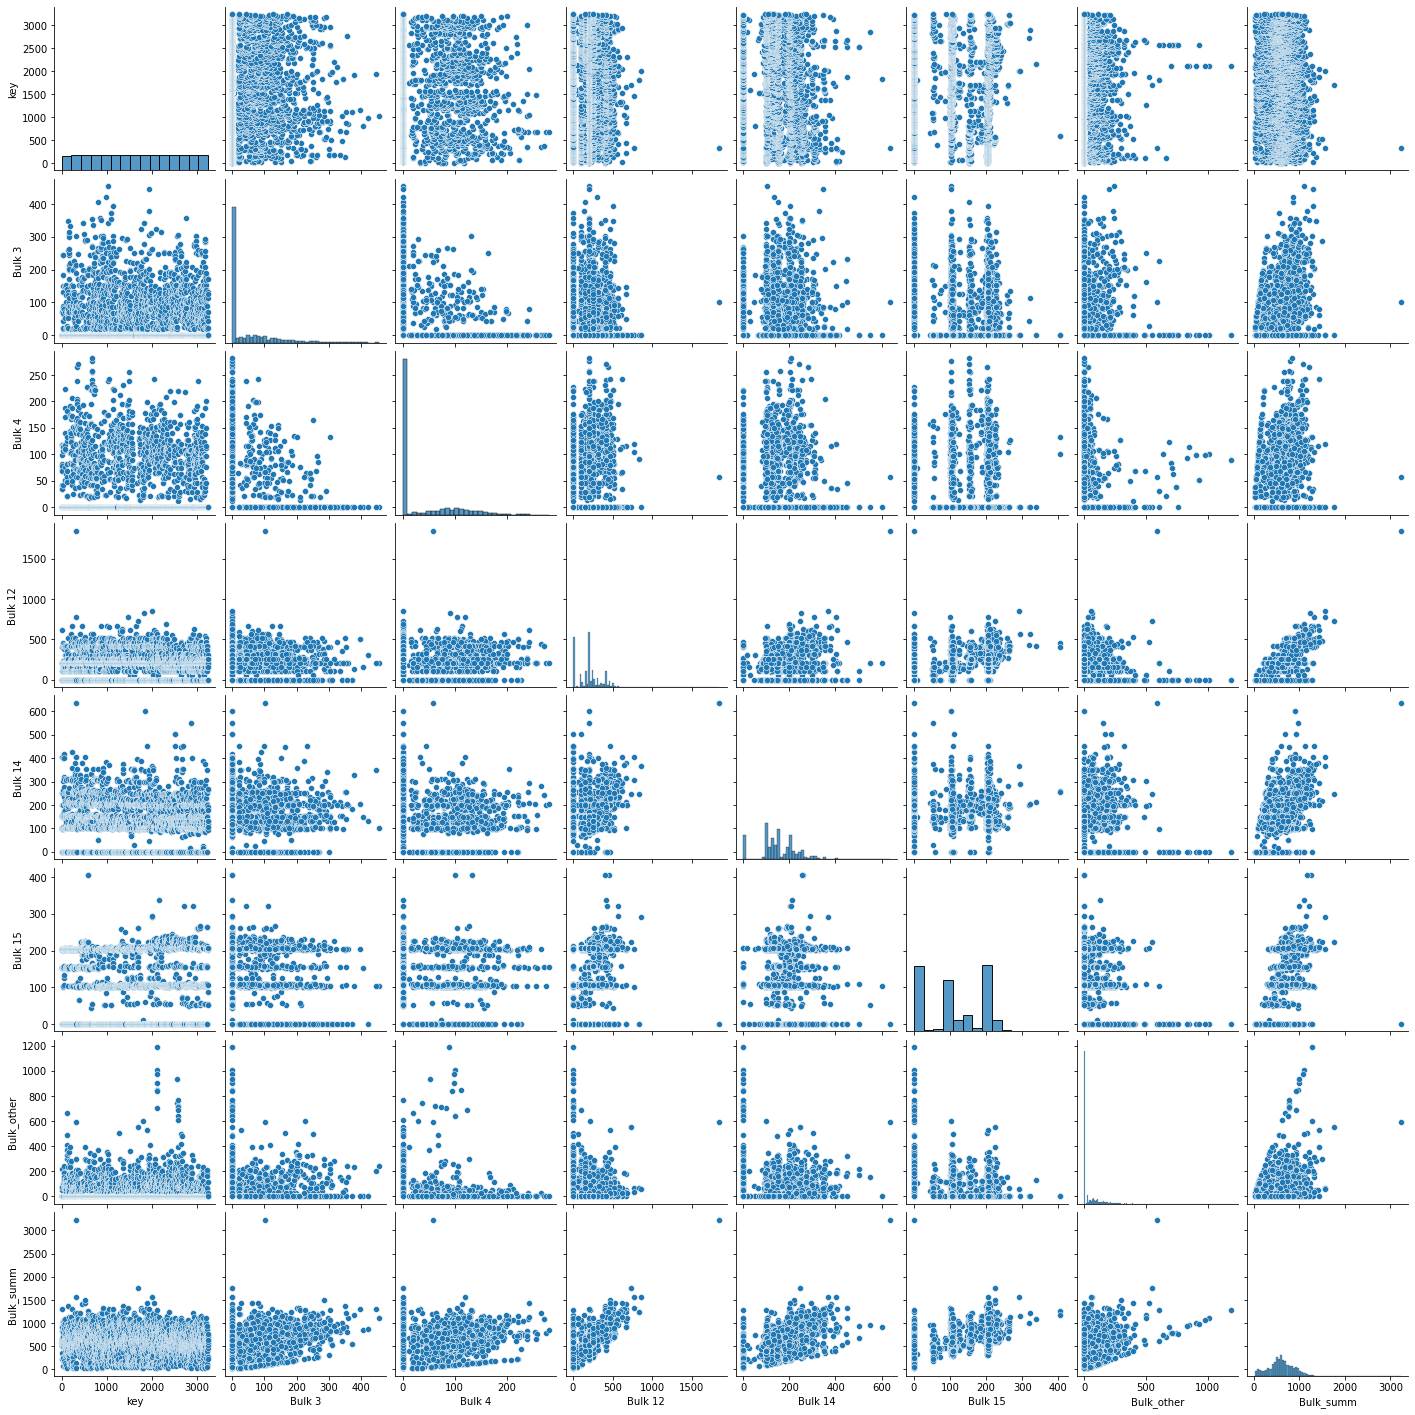

In [88]:
sns.pairplot(data_bulk, diag_kind='hist')

Видим много нулевых значений, но как мы ранее определили эти значения нам нужны, выбросами считать их не будем. Среди всех распределений особенно выделяются данные по 15-й добавке. Мы видим 3 четких уровня. Рассмотрим эту добавку поближе.

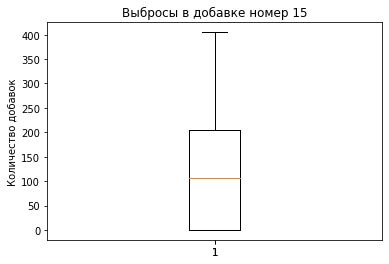

Выбросов в продажах:  0


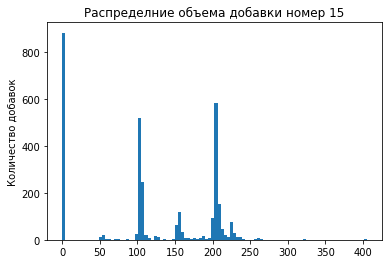

In [89]:
# Выводим диаграмму размаха
boxplot = plt.boxplot(data_bulk['Bulk 15'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_bulk['Bulk 15'].values)
plt.ylabel('Количество добавок')
plt.title("Выбросы в добавке номер 15")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

# График распределения
plt.hist(data_bulk['Bulk 15'].values,bins=100)
plt.ylabel('Количество добавок')
plt.title("Распределние объема добавки номер 15")
plt.show() 

Помимо пика около нуля видны сильные пики в районе 100, 150 и 200 единиц. Возможно это связано с технологическим процессом, стоит показать заказчику, возможно эта добавка требует точной дозировки, но в некоторых случаях она нарушена,и это может влиять на качество продукции. Либо эти погрешности в пределах технологических регламентов. 
Что примечательно на диаграмме размаха нет выбросов, т.е. косвено подтверждается что нулевые значения стоит использовать.  
  
Так же на графике общего объема выделяется точка. Посмотрим на диаграмму размаха.

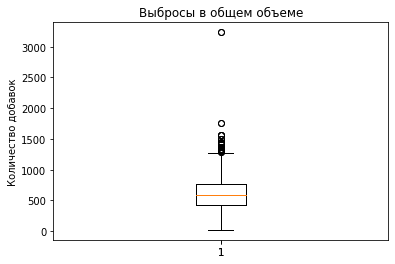

Выбросов в продажах:  21


In [90]:
# Выводим диаграмму размаха
boxplot = plt.boxplot(data_bulk['Bulk_summ'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_bulk['Bulk_summ'].values)
plt.ylabel('Количество добавок')
plt.title("Выбросы в общем объеме")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

Явно выделяется одна аномалии с общим объемом материалов более 3000.Это явно выброс - удалим его.

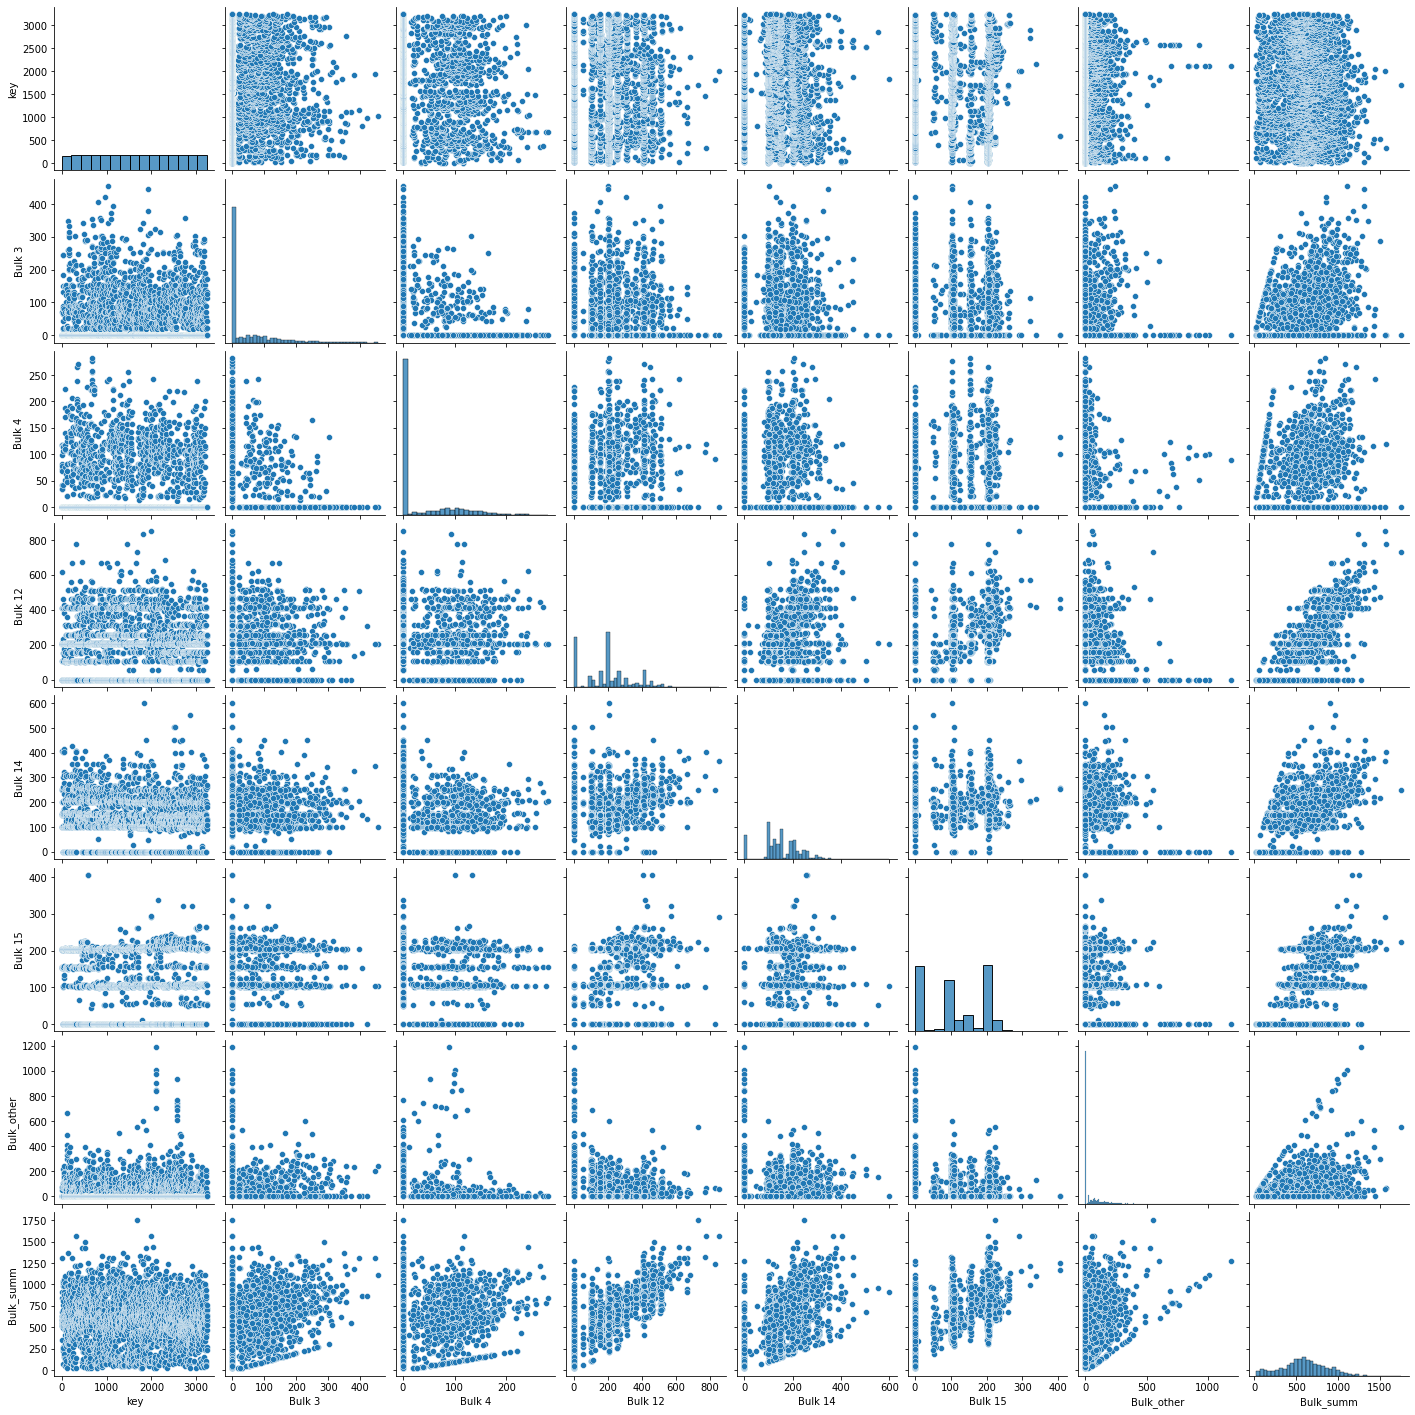

In [91]:
#Удаляем аномалию
anomaly = data_bulk[data_bulk['Bulk_summ']>3000].index
data_bulk=data_bulk.drop(anomaly)
sns.pairplot(data_bulk, diag_kind='hist')

In [92]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3128 non-null   int64  
 1   Bulk 3      3128 non-null   float64
 2   Bulk 4      3128 non-null   float64
 3   Bulk 12     3128 non-null   float64
 4   Bulk 14     3128 non-null   float64
 5   Bulk 15     3128 non-null   float64
 6   Bulk_other  3128 non-null   float64
 7   Bulk_summ   3128 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 219.9 KB


key  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  Bulk_other  Bulk_summ
0    1     0.0    43.0    206.0    150.0    154.0         0.0      553.0
1    2     0.0    73.0    206.0    149.0    154.0         0.0      582.0
2    3     0.0    34.0    205.0    152.0    153.0         0.0      544.0
3    4     0.0    81.0    207.0    153.0    154.0         0.0      595.0
4    5     0.0    78.0    203.0    151.0    152.0         0.0      584.0

#### Выводы и рекомендации.
С помощью датасета времени добавления материалов мы подтвердили корректность выгруженных данных, и смогли заполнить пропуски датасета с объемом нулями.  

Если убрать нулевые значения, то большинство признаков имеет нормальное распределение, но в нашем случае 0 это тоже показатель,т.к. от добавок может зависить конечная температура, поэтмоу мы их не стали удалять.  
Вопросы заказчику:  
- Рекомендовать проверить смесеобразование 15-й добавки на наличие ошибк в дозировке.  
- Уточнить значения объема для разных добавок( нам они каждутся однородными, но может быть одни в кг други в ц а третьи в тоннах)  
  
По итогу мы получили 3129 объектов по 7 признаков с нормальным распределением кроме добавки номер 15

Теперь перейдем к проволочным материалам и схожим образом рассмотим их.  
### Изучение данных о проволочных материалах.
Для начала отобразим два датасета data_wire и data_wire_time

In [93]:
data_wire.info()
data_wire.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [94]:
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

В обоих датафреймах 3081 объект по 9 одинаковых признаков с одинаковым количеством ненулевых значений в каждом стоблце. Поступим так же как и с сыпучими материалами и проверим, насколько соответствуют места пропусков в двух датафреймах.

In [95]:
# переделываем датафрейм в 0 и 1
na_data_wire = data_wire.isnull()
na_data_wire[na_data_wire == True] = 1
na_data_wire[na_data_wire == False] = 0

na_data_wire_time = data_wire_time.isnull()
na_data_wire_time[na_data_wire_time == True] = 1
na_data_wire_time[na_data_wire_time == False] = 0
# Проверяем датафреймы на соответствие.
na_new = pd.DataFrame()
for i in na_data_wire.columns:
    na_new[i] = na_data_wire[i] + na_data_wire_time[i]
    na_new[i] = na_new[i].astype(int)
    print(i,na_new[i].unique())
na_new.head()

key [0]
Wire 1 [0 2]
Wire 2 [2 0]
Wire 3 [2 0]
Wire 4 [2 0]
Wire 5 [2 0]
Wire 6 [2 0]
Wire 7 [2 0]
Wire 8 [2 0]
Wire 9 [2 0]


key  Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0    0       0       2       2       2       2       2       2       2       2
1    0       0       2       2       2       2       2       2       2       2
2    0       0       2       2       2       2       2       2       2       2
3    0       0       2       2       2       2       2       2       2       2
4    0       0       0       2       2       2       2       2       2       2

значений кроме нуля и двойки нет, значит все хорошо, и каждое значение датафрейме с объемом соответствует наличию даты добавления в в датафреме с временем.Значит ошибок выгрузки  нет.

Теперь вернемся к объему:

In [96]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Видно что здесь так же есть проволочные добавки, которые используются максимум  в двух процентах случаев. поэтому имеет смысл их объединить в одну группу, но на всякий случай, чтобы избежать ошибок посмотрим на среднюю,медиану и однородность данных:

In [97]:
display(data_wire.mean(),data_wire.median(),data_wire)

key       1623.426485
Wire 1     100.895853
Wire 2      50.577323
Wire 3     189.482681
Wire 4      57.442841
Wire 5      15.132000
Wire 6      48.016974
Wire 7      10.039007
Wire 8      53.625193
Wire 9      34.155752
dtype: float64

key       1619.000000
Wire 1     100.158234
Wire 2      40.142956
Wire 3     235.194977
Wire 4      45.234282
Wire 5      15.132000
Wire 6      42.076324
Wire 7       9.017009
Wire 8      46.279999
Wire 9      30.066399
dtype: float64

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

Можно заметить, что материал под номером 3 в случае его добавления используется в объеме в среднем в два раза больше чем самый популярный материал под номером 1 который используется почти всегда.  
Интересно при использовании 3-го проволочного материала первый используется?

In [98]:
display(data_wire[data_wire['Wire 3'].isnull() == False].head(10))
print("медиана объема первой проволки при использовании третей =",data_wire[data_wire['Wire 3'].isnull() == False]['Wire 1'].median())

key      Wire 1      Wire 2      Wire 3     Wire 4  Wire 5     Wire 6  \
21    22  144.755523   99.910721  250.041794        NaN     NaN        NaN   
22    23  100.158234  114.907524  276.324066        NaN     NaN        NaN   
97   113    7.556640         NaN   96.047951  24.148801     NaN  60.094322   
98   114         NaN         NaN   88.648567  43.065361     NaN  54.122643   
101  117         NaN         NaN   93.068977        NaN     NaN  26.975523   
102  118         NaN         NaN   94.990898  33.182243     NaN  60.025684   
103  119         NaN         NaN   93.117027        NaN     NaN  43.174561   
107  123  170.220947         NaN  231.110901        NaN     NaN  40.051441   
108  124  175.156799         NaN  254.077850        NaN     NaN  40.085762   
109  125  120.382073         NaN  260.131897        NaN     NaN  65.310967   

     Wire 7  Wire 8  Wire 9  
21      NaN     NaN     NaN  
22      NaN     NaN     NaN  
97      NaN     NaN     NaN  
98      NaN     NaN     NaN  
101     NaN     NaN     NaN  
102     NaN     NaN     NaN  
103     NaN     NaN     NaN  
107     NaN     NaN     NaN  
108     NaN     NaN     NaN  
109     NaN     NaN     NaN

медиана объема первой проволки при использовании третей = 121.8453585


Медиана по расходу первого материала выросла на 20% в случае если добавляется 3-й. Возможно это какая-то альтернатива первому материалу, или даже примесь, которая увеличивает расход основной. 

Проверим заодно и коэфициент корреляции, возможно увидим взаимосвязи.

In [99]:
print(data_wire.corr())

             key    Wire 1    Wire 2    Wire 3    Wire 4  Wire 5    Wire 6  \
key     1.000000 -0.083352 -0.005461 -0.084460  0.389064     NaN  0.082274   
Wire 1 -0.083352  1.000000 -0.030892  0.724370  0.054001     NaN -0.280807   
Wire 2 -0.005461 -0.030892  1.000000 -0.081852       NaN     NaN -0.265706   
Wire 3 -0.084460  0.724370 -0.081852  1.000000  0.069854     NaN -0.221602   
Wire 4  0.389064  0.054001       NaN  0.069854  1.000000     NaN  0.237456   
Wire 5       NaN       NaN       NaN       NaN       NaN     NaN       NaN   
Wire 6  0.082274 -0.280807 -0.265706 -0.221602  0.237456     NaN  1.000000   
Wire 7  0.578898 -0.035072       NaN -0.056948 -0.404865     NaN -0.224093   
Wire 8  0.323891  0.068697  0.250477       NaN       NaN     NaN       NaN   
Wire 9 -0.012200  0.010104  0.011019       NaN       NaN     NaN       NaN   

          Wire 7    Wire 8    Wire 9  
key     0.578898  0.323891 -0.012200  
Wire 1 -0.035072  0.068697  0.010104  
Wire 2       NaN  0.2504

Коэффициент корреляции так же подтверждает прямую взаимосвязсь между 1-м и 3-м проволочными материалами. Определнно стоит обратить внимание заказчика на это.  

Теперь, заполним пропуски датасета с объемом  нулями, объединим 4,5,6 в группу другие, и посчитаем общий объем добавок.

In [100]:
# заполняем пропуски нулями и складываем редкие добавки
data_wire = data_wire.fillna(0)
data_wire['wire_other'] = (data_wire['Wire 4'] + data_wire['Wire 5'] + data_wire['Wire 6'] +
                          data_wire['Wire 7']+ data_wire['Wire 8']+data_wire['Wire 9'])
data_wire = data_wire.drop(['Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9',],axis = 1)
                         
data_wire.head()


key     Wire 1   Wire 2  Wire 3  wire_other
0    1  60.059998  0.00000     0.0         0.0
1    2  96.052315  0.00000     0.0         0.0
2    3  91.160157  0.00000     0.0         0.0
3    4  89.063515  0.00000     0.0         0.0
4    5  89.238236  9.11456     0.0         0.0

In [101]:
# Добавляем общую сумму.
data_wire['wire_summ'] = (data_wire['Wire 1'] + data_wire['Wire 2'] + data_wire['Wire 3'] + data_wire['wire_other'])
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   Wire 1      3081 non-null   float64
 2   Wire 2      3081 non-null   float64
 3   Wire 3      3081 non-null   float64
 4   wire_other  3081 non-null   float64
 5   wire_summ   3081 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 144.5 KB


key     Wire 1   Wire 2  Wire 3  wire_other  wire_summ
0    1  60.059998  0.00000     0.0         0.0  60.059998
1    2  96.052315  0.00000     0.0         0.0  96.052315
2    3  91.160157  0.00000     0.0         0.0  91.160157
3    4  89.063515  0.00000     0.0         0.0  89.063515
4    5  89.238236  9.11456     0.0         0.0  98.352796

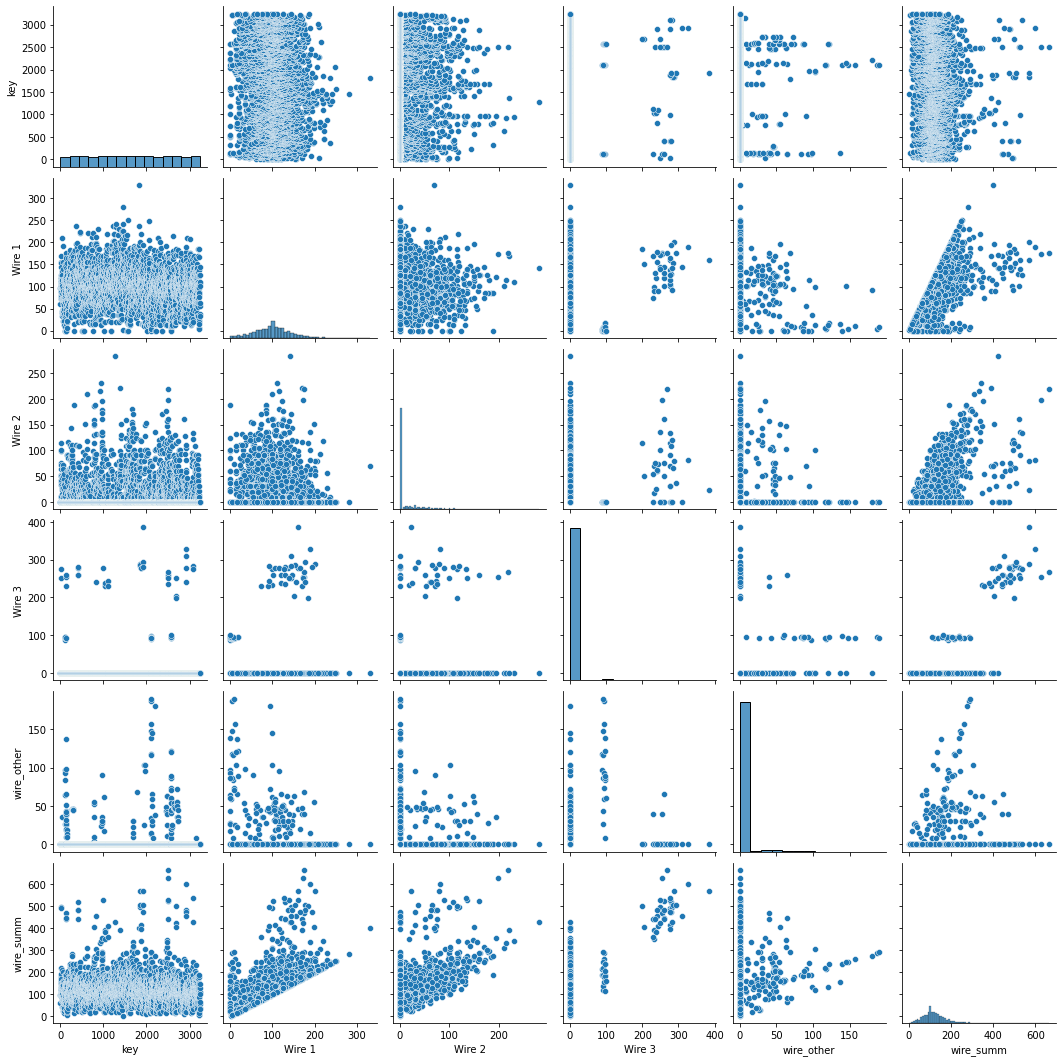

In [102]:
sns.pairplot(data_wire, diag_kind='hist')

#### Выводы и рекомендации  
Мы получили 3081 объект по 5 признаков для каждого. С помощью временного датасета проверили соответствие значений объема добавок наличию времени добавления. Это позволило заполнить пропуски нулями.

- Выявили зависимость между 1-м и 3-м проволочными материалами(Увеличение одного приводит ку величению расхода другого)   
- Объединили мелкие материалы в одну группу  
- Добавили общий объем проволочных добавок  
- Очевидных выбросов на диагарамах рассеивания не наблюдается.  
  
Рекомендации и вопросы заказчику :  
- Уточнить у заказчика единицы измерения объема для всех типов материалов.
- Предложить заказчку проверить что за 3-й проволочный материал, насколько он необходим в технологическом процессе.

### Изучение данных о продувке сплава газом;

In [103]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Всего две колонки и 3239 объекта. посмотрим на выбросы и распределение колонки Газ 1. 

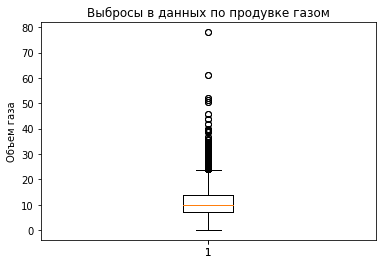

Выбросов в продажах:  126


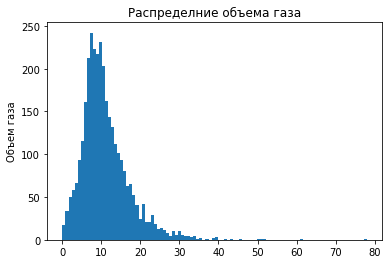

In [104]:
# Выводим диаграмму размаха
boxplot = plt.boxplot(data_gas['Газ 1'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_gas['Газ 1'].values)
plt.ylabel('Объем газа')
plt.title("Выбросы в данных по продувке газом")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

# График распределения
plt.hist(data_gas['Газ 1'].values,bins=100)
plt.ylabel('Объем газа')
plt.title("Распределние объема газа")
plt.show() 

Распределение газа имеет нормальное распределение без явно выраженных аномалий. Тем не менее на диаграмме размах присутствует 126 выбросов, 2 из которых явнл выбиваются из общей массы.Их стоит удалить, остальные стоит оставить, тк.к они могут быть индикаторами и влиять после объединения данных по объектам.

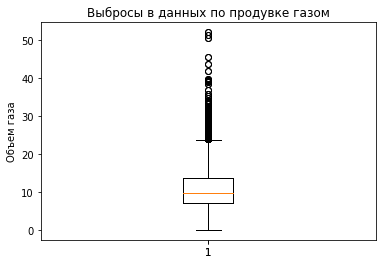

Выбросов в продажах:  124


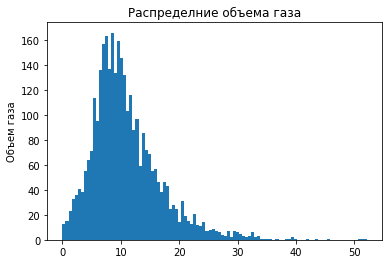

In [105]:
#Удаляем аномалию
anomaly = data_gas[data_gas['Газ 1']>60].index
data_gas=data_gas.drop(anomaly)

# Выводим диаграмму размаха
boxplot = plt.boxplot(data_gas['Газ 1'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
plt.boxplot(data_gas['Газ 1'].values)
plt.ylabel('Объем газа')
plt.title("Выбросы в данных по продувке газом")
plt.show() 
print("Выбросов в продажах: ", len(outliers)) 

# График распределения
plt.hist(data_gas['Газ 1'].values,bins=100)
plt.ylabel('Объем газа')
plt.title("Распределние объема газа")
plt.show() 

#### Выводы и рекомендации.  
Получили готвые для объединения данные по объему потраченого газа.  
Обнаружили 2 аномалии, которые удалили.  
Имеем 1 признак и 3239 объектов.  

Отдельных рекомендаций и вопросов по этому датасету нет.

### Изучение данных по измерению температуры

In [106]:

data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

Имеем 18 092 объектов и 2 признака :  
- Время замера 
- Температура  
  
При этом данны по температуре есть только у 14665 объектов.

Стоит обратить внимание что индикатор партии "кey" повторяется несколько раз, соответственно перед нами скорее всего данне не только по конечной, но и начальной и промежуточной температурам.
  
Для начала посмотрим на распределние признаков, предварительно переведя время замера к типу данных datetime, для возможности работы с ними

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


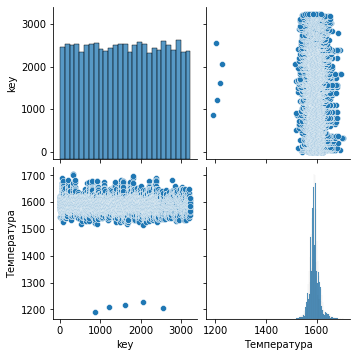

In [107]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format ='%Y-%m-%d %H:%M:%S')
data_temp.info()
sns.pairplot(data_temp)

Распределение температуры выглядит нормальным. И видны 5 температурных аномалий. Сразу удалим их:

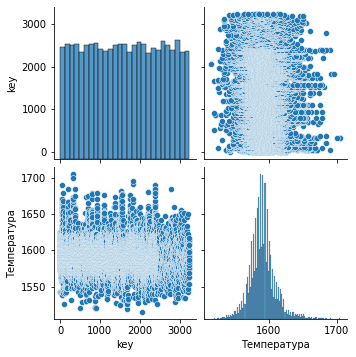

In [108]:
#Удаляем аномалию
anomaly = data_temp[data_temp['Температура']<1300].index
data_temp=data_temp.drop(anomaly)
sns.pairplot(data_temp)

Теперь все красиво.  
  
В столбце "Температура" содержится наш целевой признак, а именно конечная температура, так же нам понадобится начальная температура, т.к. от нее и продолжительности нагрева так же может зависеть целевая.В данный момент удалять пропуски не будем, т.к. если в партии есть промежуточный признак, а начальный пропущен, то из-за удаления пропусков сейчас при группировке ближайшее промежуточное значение начнет считаться стартовым, что не правильно.Поэтому заполним пропуски значением -1, и уже после группировки удалим все оставшиеся партии со значением температуры -1. 

In [109]:
data_temp = data_temp.fillna(-1)
data_temp.info()
display(data_temp.head(10))
display(data_temp.value_counts(subset='key'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18087 non-null  int64         
 1   Время замера  18087 non-null  datetime64[ns]
 2   Температура   18087 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 565.2 KB


key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
5    1 2019-05-03 11:30:38       1613.0
6    2 2019-05-03 11:34:04       1581.0
7    2 2019-05-03 11:38:40       1577.0
8    2 2019-05-03 11:46:09       1589.0
9    2 2019-05-03 11:49:38       1604.0

key
2108    17
1689    16
1513    16
2567    15
46      14
        ..
2841     2
556      2
943      2
279      1
195      1
Length: 3216, dtype: int64

В столбце "время замера" на примере партии номер 195 мы видим всего 1 замер температуры,а в партии 2108 измерений было вообще 17, однако нам нужны только первое измерение, которое будем считать начальным, и последнее, которое будем считать целевым.А чтобы не было путаницы строки ,где был всего один замер удалим, предварительно проверив их количество.

In [110]:
print("Количество строк с одним измерением:",
      data_temp.value_counts(subset='key')[data_temp.value_counts(subset='key') == 1].count())
indexes = data_temp.value_counts(subset='key')[data_temp.value_counts(subset='key') == 1].index
data_temp = data_temp[data_temp['key'].isin(indexes) == False]


Количество строк с одним измерением: 2


In [111]:
display(data_temp.value_counts(subset='key'))

key
2108    17
1689    16
1513    16
2567    15
322     14
        ..
248      2
1568     2
247      2
2738     2
732      2
Length: 3214, dtype: int64

количество таких строк всего 2 совершенно спокойно удалили их, т.к. мы не сможем определить это было первое или последнее измерение.

Теперь отсортируем по возрастанию номера парии и времени замера, и создадим новый датафрейм, в котором есть только начальная и конечная температура.

In [112]:
#Сортируем и группируем данные в новые датафреймы
data_temp = data_temp.sort_values(['key','Время замера'])
data_temp_first = data_temp.groupby('key').first()
data_temp_last = data_temp.groupby('key').last()
# Проверяем полученный результат
data_temp_first.info()
print()
print()
print()
data_temp_last.info()
print()
print()
print()
data_temp_first.head(), data_temp_last.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  3214 non-null   datetime64[ns]
 1   Температура   3214 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.3 KB



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  3214 non-null   datetime64[ns]
 1   Температура   3214 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.3 KB





(           Время замера  Температура
 key                                 
 1   2019-05-03 11:02:04       1571.0
 2   2019-05-03 11:34:04       1581.0
 3   2019-05-03 12:06:44       1596.0
 4   2019-05-03 12:39:27       1601.0
 5   2019-05-03 13:11:03       1576.0,
            Время замера  Температура
 key                                 
 1   2019-05-03 11:30:38       1613.0
 2   2019-05-03 11:55:09       1602.0
 3   2019-05-03 12:35:57       1599.0
 4   2019-05-03 12:59:47       1625.0
 5   2019-05-03 13:36:39       1602.0)

после группировки в двух новых датафреймах осталось по 3214 партий.Тепреь объединим наши датафреймы в один, предварительно переименовав колонки со верменем замера.

In [113]:
#Переименовываем колонки
data_temp_first.columns = ['start_time', "start_temp"]
data_temp_last.columns = ['finish_time','finish_temp']

#Объединяем данные 
data_temp_new = data_temp_first.merge(data_temp_last,left_index=True, right_index=True,how="inner")

#Возвращаем номер партии в виде колонки а не индекс
data_temp_new = data_temp_new.reset_index()

#Проверяем результат 
data_temp_new.info()
data_temp_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3214 non-null   int64         
 1   start_time   3214 non-null   datetime64[ns]
 2   start_temp   3214 non-null   float64       
 3   finish_time  3214 non-null   datetime64[ns]
 4   finish_temp  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 125.7 KB


key          start_time  start_temp         finish_time  finish_temp
0    1 2019-05-03 11:02:04      1571.0 2019-05-03 11:30:38       1613.0
1    2 2019-05-03 11:34:04      1581.0 2019-05-03 11:55:09       1602.0
2    3 2019-05-03 12:06:44      1596.0 2019-05-03 12:35:57       1599.0
3    4 2019-05-03 12:39:27      1601.0 2019-05-03 12:59:47       1625.0
4    5 2019-05-03 13:11:03      1576.0 2019-05-03 13:36:39       1602.0

Данные сгруппированы, теперь, посмотрим сколько значений нам нужно удалить ориентируясь на метку температуры = -1

In [114]:
display(data_temp_new[data_temp_new['start_temp']==-1])
display(data_temp_new[data_temp_new['finish_temp']==-1])

key          start_time  start_temp         finish_time  finish_temp
2536  2561 2019-08-12 18:59:23        -1.0 2019-08-12 19:21:45         -1.0

key          start_time  start_temp         finish_time  finish_temp
2475  2500 2019-08-10 14:04:39      1539.0 2019-08-10 14:29:39         -1.0
2476  2501 2019-08-10 14:41:14      1587.0 2019-08-10 15:29:00         -1.0
2477  2502 2019-08-10 15:39:39      1583.0 2019-08-10 16:04:55         -1.0
2478  2503 2019-08-10 16:27:44      1603.0 2019-08-10 17:14:24         -1.0
2479  2504 2019-08-10 17:31:43      1583.0 2019-08-10 18:03:42         -1.0
...    ...                 ...         ...                 ...          ...
3209  3237 2019-09-06 11:31:15      1569.0 2019-09-06 11:55:45         -1.0
3210  3238 2019-09-06 12:16:15      1584.0 2019-09-06 12:34:37         -1.0
3211  3239 2019-09-06 14:16:50      1598.0 2019-09-06 15:09:55         -1.0
3212  3240 2019-09-06 15:25:21      1617.0 2019-09-06 16:35:26         -1.0
3213  3241 2019-09-06 16:48:55      1586.0 2019-09-06 17:30:05         -1.0

[739 rows x 5 columns]

Получили одно значение в колонке start_time и 739 по колонке finish_temp. Теперь удалим эти значения.

In [115]:
data_temp_new = data_temp_new[data_temp_new['start_temp']!=-1]
data_temp_new = data_temp_new[data_temp_new['finish_temp']!=-1]
#Проверяем работу кода 
display(data_temp_new[data_temp_new['start_temp']==-1])
display(data_temp_new[data_temp_new['finish_temp']==-1])
data_temp_new.info()

Empty DataFrame
Columns: [key, start_time, start_temp, finish_time, finish_temp]
Index: []

Empty DataFrame
Columns: [key, start_time, start_temp, finish_time, finish_temp]
Index: []

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2475 non-null   int64         
 1   start_time   2475 non-null   datetime64[ns]
 2   start_temp   2475 non-null   float64       
 3   finish_time  2475 non-null   datetime64[ns]
 4   finish_temp  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 116.0 KB


Получили 2475 партий. В которых содержится начальная и конечная температуры, а так же Время первого замера и последнего, которые мы можем использовать для создания еще одного признака - продолжительность производственного процесса в секундах

In [116]:
# Добавляем признак продолжительность процесса и удаляем ненужные столбцы и строки
data_temp_new['process_time'] = (data_temp_new['finish_time'] - data_temp_new['start_time']) / pd.Timedelta(seconds=1)
data_temp_new = data_temp_new.drop(['start_time','finish_time'],axis=1)
anomaly = data_temp_new[data_temp_new['finish_temp'].isnull()==True].index
data_temp_new = data_temp_new.drop(anomaly)
data_temp_new.reset_index(drop=True)
# Проверяем нет ли повторяющихся партий, после объединения и проверяем результаты.
display(data_temp_new.value_counts(subset='key',ascending=True).head())
data_temp_new.info()
data_temp_new.head()

key
1       1
1662    1
1663    1
1664    1
1665    1
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2475 non-null   int64  
 1   start_temp    2475 non-null   float64
 2   finish_temp   2475 non-null   float64
 3   process_time  2475 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 161.2 KB


key  start_temp  finish_temp  process_time
0    1      1571.0       1613.0        1714.0
1    2      1581.0       1602.0        1265.0
2    3      1596.0       1599.0        1753.0
3    4      1601.0       1625.0        1220.0
4    5      1576.0       1602.0        1536.0

In [117]:
data_temp_new

key  start_temp  finish_temp  process_time
0        1      1571.0       1613.0        1714.0
1        2      1581.0       1602.0        1265.0
2        3      1596.0       1599.0        1753.0
3        4      1601.0       1625.0        1220.0
4        5      1576.0       1602.0        1536.0
...    ...         ...          ...           ...
2470  2495      1570.0       1591.0        1380.0
2471  2496      1554.0       1591.0        1705.0
2472  2497      1571.0       1589.0         962.0
2473  2498      1591.0       1594.0        1520.0
2474  2499      1569.0       1603.0        1537.0

[2475 rows x 4 columns]

Повторяющихся партий нет, получили 2475 обектов с 3-мя признаками, один из которых целевой.
На всякий случай еще раз взглянем на распределение

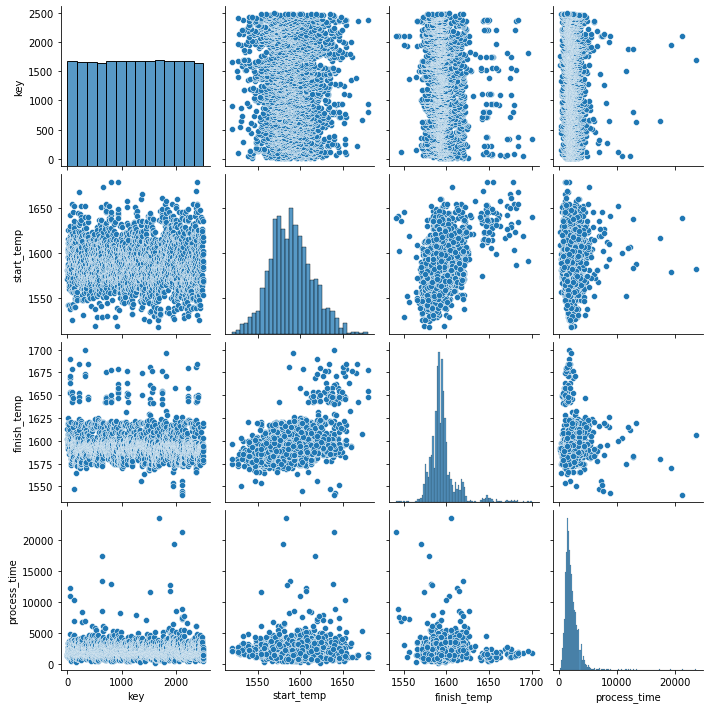

In [118]:
sns.pairplot(data_temp_new, diag_kind='hist')

#### Выводы и рекомендации. 
- Сгруппировали данные по партии, предварительно отсортировав.
- Убрали промежуточные данные по температуре.
- Удалили одну партию с отсутствующей инфомрацие по конечной температуре.
- Создали дополнительный признак "продолжительность процесса"

В результате ислледовательского анализа получили 2475 объектов с тремя признаками, один из которых целевой по задче.
Распределение признаков нормальное. Между начальной и конечной температурой наблюдается четкая линия прямой зависимости, что подтверждает правильность выбора начальной темпереатуры как признака.


### **Итоги загрузки и первичного анализа данных**

В результате анализа и базовой предобработке были сформированы 5 датафреймов, в которых объектом является номер партии "key"
количество полученных объектов:
- *3214 в данных по электродам*  
- *3129 в данных по сыпучим добавкам*  
- *3081 в данных по проволочным добавкам*  
- *3239 в данных по объему газа*  
- *2475 в данных по температуре*  
  
Общее количество признаков составило 19 шт, из которых 1 целевой:  
1) Целевой признак - *finish_temp* - Конечная температура.
2) Остальные признаки :  
    - *Активная мощность*  
    - *Реактивная мощность*  
    - *arc-time* - Продолжительность нагрева  
    - *Bulk 3* - сыпучая добавка 3  
    - *Bulk 4* - сыпучая добавка 4  
    - *Bulk 12* - сыпучая добавка 12  
    - *Bulk 14* - сыпучая добавка 14  
    - *Bulk 15* - сыпучая добавка 15  
    - *Bulk_other* - содержит общий объем сыпучих добавок частота использования которых ниже 20%  
    - *Bulk_summ* - общий объем  сыпучих добавок  
    - *Wire 1* - проволочная добавка 1  
    - *Wire 2* - проволочная добавка 2  
    - *Wire 3* - проволочная добавка 3  
    - *wire_other* - содержит общий объем проволочных добавок частота использования которых ниже 2%  
    - *wire_summ* - общий объем  сыпучих добавок  
    - *Газ 1* - объем использованого газа  
    - *start_temp* - начальная температура сплава  
    - *process_time* - общая продолжительность процесса.

Все признаки кроме *Bulk 15*(есть три четких пика, и небольшие отклонения вокруг них) имеют нормальное распределение.  
Во время исследования не было выявлено дубликатов.  
Были обнаружены и удалены единичные аномалии.  
Пропуски в данных были либо удалены, либо заполнены нулями на основании временных меток.  
  
Вопросы заказчику:

- Какие показатели мощности и продолжительности работы электродов укладываются в технологический регламент. Если иметь эти данные, то можно выяснить какие электроды и когда работают со сбоями.
- Можно ли складывать Активную и Реактивную мощность.
- Потребляемые мощности указаны совокупно за периоды указанные в датасете, или мощность указана например за 1 минуту, час и т.д.?  
- Одинаковые ли единицы измерения объема для разных сыпучих добавок(нам они каждутся однородными, но может быть одни в кг други в центнерах, а третьи в тоннах)  
- Одинаковые ли единицы измерения объема для всех типов проволочных материалов.
- Предложить заказчку проверить что за 3-й проволочный материал, насколько он необходим в технологическом процессе(т.к. при его использовании в среднем на 20% увеличивается и  расход 1-го проволочного материала.
- Рекомендовать проверить смесеобразование 15-й добавки на наличие ошибк в дозировке - большинство значений находится   в районе 100, 150 и 200 единиц, но при этом довольно много небольших отклонений от этих цифр.
  
После получения ответов от заказчика на вопросы, и внесения корректировок по единицам измерения (при необходимости) можно приступать к объединению данных в один датафрейм, на базе которог будет строиться модель.



## **Объединение и предобработка данных объединенного датафрейма**
Пришло время объединить все наши полученные датафреймы в один для создания модели. Т.к. целевой признак содержится в датасете data_temp_new, то объединять имет смысл будем с способом "left" по столбцу с номером партии "key" именно на базе датасета data_temp_new. т.к.данные без целевого признака мы исполььзовать не сможем. 

In [119]:
# Создадаем новый датафрейм, в который объединим все 5 полученных на этапе предобработки
# data_temp_new, data_gas, data_wire, data_bulk, data_arc
data_full = data_temp_new.merge(data_gas, how='left', on='key')
data_full = data_full.merge(data_arc, how='left', on='key')
data_full = data_full.merge(data_wire, how='left', on='key')
data_full = data_full.merge(data_bulk, how='left', on='key')

In [120]:
data_full.info()
data_full.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2475 non-null   int64  
 1   start_temp           2475 non-null   float64
 2   finish_temp          2475 non-null   float64
 3   process_time         2475 non-null   float64
 4   Газ 1                2471 non-null   float64
 5   arc_time             2475 non-null   float64
 6   Активная мощность    2475 non-null   float64
 7   Реактивная мощность  2475 non-null   float64
 8   Wire 1               2372 non-null   float64
 9   Wire 2               2372 non-null   float64
 10  Wire 3               2372 non-null   float64
 11  wire_other           2372 non-null   float64
 12  wire_summ            2372 non-null   float64
 13  Bulk 3               2406 non-null   float64
 14  Bulk 4               2406 non-null   float64
 15  Bulk 12              2406 non-null   f

key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
0    1      1571.0       1613.0        1714.0  29.749986    1098.0   
1    2      1581.0       1602.0        1265.0  12.555561     811.0   
2    3      1596.0       1599.0        1753.0  28.554793     655.0   
3    4      1601.0       1625.0        1220.0  18.841219     741.0   
4    5      1576.0       1602.0        1536.0   5.413692     869.0   
5    6      1543.0       1596.0        1497.0  11.273392     952.0   
6    7      1586.0       1599.0        1744.0   9.836267     673.0   
7    8      1577.0       1598.0        1615.0  15.171553     913.0   
8    9      1587.0       1592.0        1811.0   8.216623     625.0   
9   10      1574.0       1593.0        1551.0   6.529891     825.0   

   Активная мощность  Реактивная мощность      Wire 1     Wire 2  Wire 3  \
0           3.036730             2.142821   60.059998   0.000000     0.0   
1           2.139408             1.453357   96.052315   0.000000     0.0   
2           4.063641             2.937457   91.160157   0.000000     0.0   
3           2.706489             2.056992   89.063515   0.000000     0.0   
4           2.252950             1.687991   89.238236   9.114560     0.0   
5           2.725274             1.881313   99.109917   9.114560     0.0   
6           2.626877             1.960419   98.061600   0.000000     0.0   
7           2.678958             2.096952  155.282394   0.000000     0.0   
8           3.520820             2.527365  113.393279   9.143681     0.0   
9           3.118778             2.154941   81.244796  12.376000     0.0   

   wire_other   wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0         0.0   60.059998     0.0    43.0    206.0    150.0    154.0   
1         0.0   96.052315     0.0    73.0    206.0    149.0    154.0   
2         0.0   91.160157     0.0    34.0    205.0    152.0    153.0   
3         0.0   89.063515     0.0    81.0    207.0    153.0    154.0   
4         0.0   98.352796     0.0    78.0    203.0    151.0    152.0   
5         0.0  108.224477     0.0   117.0    204.0    201.0    154.0   
6         0.0   98.061600     0.0   117.0    204.0    152.0    154.0   
7         0.0  155.282394     0.0    99.0    410.0    252.0    153.0   
8         0.0  122.536960     0.0   117.0    107.0     99.0    203.0   
9         0.0   93.620796     0.0     0.0    203.0    102.0    204.0   

   Bulk_other  Bulk_summ  
0         0.0      553.0  
1         0.0      582.0  
2         0.0      544.0  
3         0.0      595.0  
4         0.0      584.0  
5         0.0      676.0  
6         0.0      627.0  
7         0.0      914.0  
8         0.0      526.0  
9         0.0      509.0

Получили таблицу с 20 колонками, из которых 1-й номер партии, 1 целевой признак и 18 обычных. Колонки не потерялись.  
  
Проведем небольшую предобработку и анализ объединенного датафрейма:
- проверим на дубликаты
- проверим и удалим или заполним пропуски.
- посмотрим на графики взаимосвязей


In [121]:
print("Количество дубликатов:", data_full.duplicated().sum())
print()
print("Количество пропусков:")
print(data_full.isna().sum())

Количество дубликатов: 0

Количество пропусков:
key                      0
start_temp               0
finish_temp              0
process_time             0
Газ 1                    4
arc_time                 0
Активная мощность        0
Реактивная мощность      0
Wire 1                 103
Wire 2                 103
Wire 3                 103
wire_other             103
wire_summ              103
Bulk 3                  69
Bulk 4                  69
Bulk 12                 69
Bulk 14                 69
Bulk 15                 69
Bulk_other              69
Bulk_summ               69
dtype: int64


Полных явных дубликатов 0, пропуски содержатся в основном в данных по проволочным и сыпучим добавкам. Рассмотрим их поближе

In [122]:
# Выведем строки с пропусками в данных по газу
print("количество строк с пропусками :", len(data_full[data_full['Газ 1'].isnull() == True]))
data_full[data_full['Газ 1'].isnull() == True]
      

количество строк с пропусками : 4


key  start_temp  finish_temp  process_time  Газ 1  arc_time  \
190  193      1593.0       1595.0        3071.0    NaN    1040.0   
255  259      1577.0       1590.0        1484.0    NaN     717.0   
275  280      1532.0       1600.0        3169.0    NaN    1807.0   
317  322      1619.0       1616.0        7011.0    NaN    2658.0   

     Активная мощность  Реактивная мощность      Wire 1      Wire 2  Wire 3  \
190           4.494506             3.126126  122.129272    0.000000     0.0   
255           2.307336             1.613320   55.080479    0.000000     0.0   
275           4.248512             2.967820  160.174557   76.236166     0.0   
317           8.914806             6.564143    0.000000  188.228550     0.0   

     wire_other   wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
190    0.000000  122.129272     0.0   192.0    207.0    111.0    204.0   
255    0.000000   55.080479     0.0     0.0    106.0    206.0    103.0   
275   46.002319  282.413042   126.0     0.0    108.0    263.0      0.0   
317    0.000000  188.228550     NaN     NaN      NaN      NaN      NaN   

     Bulk_other  Bulk_summ  
190         0.0      714.0  
255       141.0      556.0  
275        63.0      560.0  
317         NaN        NaN

In [123]:
# Выведем строки с пропусками в данных по электродам
print("количество строк с пропусками :", len(data_full[data_full['arc_time'].isnull() == True]))
data_full[data_full['arc_time'].isnull() == True].head()

количество строк с пропусками : 0


Empty DataFrame
Columns: [key, start_temp, finish_temp, process_time, Газ 1, arc_time, Активная мощность, Реактивная мощность, Wire 1, Wire 2, Wire 3, wire_other, wire_summ, Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15, Bulk_other, Bulk_summ]
Index: []

In [124]:
# Выведем строки с пропусками в данных по сыпучим материалам
print("количество строк с пропусками :", len(data_full[data_full['Bulk 3'].isnull() == True]))
data_full[data_full['Bulk 3'].isnull() == True].head()

количество строк с пропусками : 69


key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
48   51      1619.0       1690.0        1816.0   9.236758    1293.0   
49   52      1617.0       1669.0        2549.0  14.119615    1416.0   
50   53      1642.0       1671.0        1885.0   7.090307    1048.0   
51   54      1630.0       1663.0        1967.0   5.547380     877.0   
52   55      1615.0       1654.0        1872.0   8.915683    1021.0   

    Активная мощность  Реактивная мощность  Wire 1  Wire 2  Wire 3  \
48           2.341395             1.701087     NaN     NaN     NaN   
49           4.151573             3.169576     NaN     NaN     NaN   
50           3.138915             2.327981     NaN     NaN     NaN   
51           2.509666             1.925558     NaN     NaN     NaN   
52           2.929823             2.023598     NaN     NaN     NaN   

    wire_other  wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
48         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
49         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
50         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
51         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
52         NaN        NaN     NaN     NaN      NaN      NaN      NaN   

    Bulk_other  Bulk_summ  
48         NaN        NaN  
49         NaN        NaN  
50         NaN        NaN  
51         NaN        NaN  
52         NaN        NaN

In [125]:
# Выведем строки с пропусками в данных по проволочным материалам
print("количество строк с пропусками :", len(data_full[data_full['Wire 2'].isnull() == True]))
data_full[data_full['Wire 2'].isnull() == True].head()

количество строк с пропусками : 103


key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
48   51      1619.0       1690.0        1816.0   9.236758    1293.0   
49   52      1617.0       1669.0        2549.0  14.119615    1416.0   
50   53      1642.0       1671.0        1885.0   7.090307    1048.0   
51   54      1630.0       1663.0        1967.0   5.547380     877.0   
52   55      1615.0       1654.0        1872.0   8.915683    1021.0   

    Активная мощность  Реактивная мощность  Wire 1  Wire 2  Wire 3  \
48           2.341395             1.701087     NaN     NaN     NaN   
49           4.151573             3.169576     NaN     NaN     NaN   
50           3.138915             2.327981     NaN     NaN     NaN   
51           2.509666             1.925558     NaN     NaN     NaN   
52           2.929823             2.023598     NaN     NaN     NaN   

    wire_other  wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
48         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
49         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
50         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
51         NaN        NaN     NaN     NaN      NaN      NaN      NaN   
52         NaN        NaN     NaN     NaN      NaN      NaN      NaN   

    Bulk_other  Bulk_summ  
48         NaN        NaN  
49         NaN        NaN  
50         NaN        NaN  
51         NaN        NaN  
52         NaN        NaN

Как видим пропуски во всех случаях однородны(если данных нет по одному признаку из исходного датасета, то их нет и по остальным признакам этого же датасета), т.е. это означает что в их датасетах попросту не было данных по конкретным партиям. К сожалению как и раньше мы не можем заполнить средними значениями эти данные, и у нас нет основания предполагать что в этих партиях данные признаки равны нулю, поэтому придется все пропуски удалить 

In [126]:
data_full = data_full.dropna()
data_full.info()
data_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2474
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2327 non-null   int64  
 1   start_temp           2327 non-null   float64
 2   finish_temp          2327 non-null   float64
 3   process_time         2327 non-null   float64
 4   Газ 1                2327 non-null   float64
 5   arc_time             2327 non-null   float64
 6   Активная мощность    2327 non-null   float64
 7   Реактивная мощность  2327 non-null   float64
 8   Wire 1               2327 non-null   float64
 9   Wire 2               2327 non-null   float64
 10  Wire 3               2327 non-null   float64
 11  wire_other           2327 non-null   float64
 12  wire_summ            2327 non-null   float64
 13  Bulk 3               2327 non-null   float64
 14  Bulk 4               2327 non-null   float64
 15  Bulk 12              2327 non-null   f

key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
0    1      1571.0       1613.0        1714.0  29.749986    1098.0   
1    2      1581.0       1602.0        1265.0  12.555561     811.0   
2    3      1596.0       1599.0        1753.0  28.554793     655.0   
3    4      1601.0       1625.0        1220.0  18.841219     741.0   
4    5      1576.0       1602.0        1536.0   5.413692     869.0   

   Активная мощность  Реактивная мощность     Wire 1   Wire 2  Wire 3  \
0           3.036730             2.142821  60.059998  0.00000     0.0   
1           2.139408             1.453357  96.052315  0.00000     0.0   
2           4.063641             2.937457  91.160157  0.00000     0.0   
3           2.706489             2.056992  89.063515  0.00000     0.0   
4           2.252950             1.687991  89.238236  9.11456     0.0   

   wire_other  wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0         0.0  60.059998     0.0    43.0    206.0    150.0    154.0   
1         0.0  96.052315     0.0    73.0    206.0    149.0    154.0   
2         0.0  91.160157     0.0    34.0    205.0    152.0    153.0   
3         0.0  89.063515     0.0    81.0    207.0    153.0    154.0   
4         0.0  98.352796     0.0    78.0    203.0    151.0    152.0   

   Bulk_other  Bulk_summ  
0         0.0      553.0  
1         0.0      582.0  
2         0.0      544.0  
3         0.0      595.0  
4         0.0      584.0

После удаления пропусков осталось 2889 объектов из 3085. Мы потеряли порядка 6% объектов. С учетом объема нашей вборки вполне приемлемо.Еще раз посмотрим на наши данные:

In [127]:
data_full.head(10)

key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
0    1      1571.0       1613.0        1714.0  29.749986    1098.0   
1    2      1581.0       1602.0        1265.0  12.555561     811.0   
2    3      1596.0       1599.0        1753.0  28.554793     655.0   
3    4      1601.0       1625.0        1220.0  18.841219     741.0   
4    5      1576.0       1602.0        1536.0   5.413692     869.0   
5    6      1543.0       1596.0        1497.0  11.273392     952.0   
6    7      1586.0       1599.0        1744.0   9.836267     673.0   
7    8      1577.0       1598.0        1615.0  15.171553     913.0   
8    9      1587.0       1592.0        1811.0   8.216623     625.0   
9   10      1574.0       1593.0        1551.0   6.529891     825.0   

   Активная мощность  Реактивная мощность      Wire 1     Wire 2  Wire 3  \
0           3.036730             2.142821   60.059998   0.000000     0.0   
1           2.139408             1.453357   96.052315   0.000000     0.0   
2           4.063641             2.937457   91.160157   0.000000     0.0   
3           2.706489             2.056992   89.063515   0.000000     0.0   
4           2.252950             1.687991   89.238236   9.114560     0.0   
5           2.725274             1.881313   99.109917   9.114560     0.0   
6           2.626877             1.960419   98.061600   0.000000     0.0   
7           2.678958             2.096952  155.282394   0.000000     0.0   
8           3.520820             2.527365  113.393279   9.143681     0.0   
9           3.118778             2.154941   81.244796  12.376000     0.0   

   wire_other   wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0         0.0   60.059998     0.0    43.0    206.0    150.0    154.0   
1         0.0   96.052315     0.0    73.0    206.0    149.0    154.0   
2         0.0   91.160157     0.0    34.0    205.0    152.0    153.0   
3         0.0   89.063515     0.0    81.0    207.0    153.0    154.0   
4         0.0   98.352796     0.0    78.0    203.0    151.0    152.0   
5         0.0  108.224477     0.0   117.0    204.0    201.0    154.0   
6         0.0   98.061600     0.0   117.0    204.0    152.0    154.0   
7         0.0  155.282394     0.0    99.0    410.0    252.0    153.0   
8         0.0  122.536960     0.0   117.0    107.0     99.0    203.0   
9         0.0   93.620796     0.0     0.0    203.0    102.0    204.0   

   Bulk_other  Bulk_summ  
0         0.0      553.0  
1         0.0      582.0  
2         0.0      544.0  
3         0.0      595.0  
4         0.0      584.0  
5         0.0      676.0  
6         0.0      627.0  
7         0.0      914.0  
8         0.0      526.0  
9         0.0      509.0

In [128]:
data_full

key  start_temp  finish_temp  process_time      Газ 1  arc_time  \
0        1      1571.0       1613.0        1714.0  29.749986    1098.0   
1        2      1581.0       1602.0        1265.0  12.555561     811.0   
2        3      1596.0       1599.0        1753.0  28.554793     655.0   
3        4      1601.0       1625.0        1220.0  18.841219     741.0   
4        5      1576.0       1602.0        1536.0   5.413692     869.0   
...    ...         ...          ...           ...        ...       ...   
2470  2495      1570.0       1591.0        1380.0   7.125735     723.0   
2471  2496      1554.0       1591.0        1705.0   9.412616     940.0   
2472  2497      1571.0       1589.0         962.0   6.271699     569.0   
2473  2498      1591.0       1594.0        1520.0  14.953657     750.0   
2474  2499      1569.0       1603.0        1537.0  11.336151     883.0   

      Активная мощность  Реактивная мощность      Wire 1    Wire 2  Wire 3  \
0              3.036730             2.142821   60.059998   0.00000     0.0   
1              2.139408             1.453357   96.052315   0.00000     0.0   
2              4.063641             2.937457   91.160157   0.00000     0.0   
3              2.706489             2.056992   89.063515   0.00000     0.0   
4              2.252950             1.687991   89.238236   9.11456     0.0   
...                 ...                  ...         ...       ...     ...   
2470           3.168133             2.210936   89.150879   0.00000     0.0   
2471           4.174918             2.872031  114.179527   0.00000     0.0   
2472           3.605239             2.452092   94.086723   9.04800     0.0   
2473           3.202310             2.239820  118.110717   0.00000     0.0   
2474           1.737084             1.296836  110.160958  50.00528     0.0   

      wire_other   wire_summ  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0            0.0   60.059998     0.0    43.0    206.0    150.0    154.0   
1            0.0   96.052315     0.0    73.0    206.0    149.0    154.0   
2            0.0   91.160157     0.0    34.0    205.0    152.0    153.0   
3            0.0   89.063515     0.0    81.0    207.0    153.0    154.0   
4            0.0   98.352796     0.0    78.0    203.0    151.0    152.0   
...          ...         ...     ...     ...      ...      ...      ...   
2470         0.0   89.150879    21.0     0.0    256.0    129.0    223.0   
2471         0.0  114.179527     0.0    63.0    256.0    129.0    226.0   
2472         0.0  103.134723     0.0    85.0    230.0    124.0    226.0   
2473         0.0  118.110717    90.0     0.0    206.0    129.0    207.0   
2474         0.0  160.166238    47.0     0.0    233.0    126.0    227.0   

      Bulk_other  Bulk_summ  
0            0.0      553.0  
1            0.0      582.0  
2            0.0      544.0  
3            0.0      595.0  
4            0.0      584.0  
...          ...        ...  
2470        90.0      719.0  
2471       122.0      796.0  
2472         0.0      665.0  
2473       101.0      733.0  
2474         0.0      633.0  

[2327 rows x 20 columns]

Видно что наши признаки имеют довольно сильно различающиеся значения и все они числовые, поэтому после разделения нашего датасета на тестовую и обучающую необходимо будет стандартизировать признаки обучающей.  
Т.к. исcледование распределений признаков мы провели раньше, а взаимосвязь между целевым признаком проверим после проверки модели во время анализа важности признаков, то можем переходить к Подготовке построения модели.
   

In [129]:
data_full[data_full['process_time']==0]

Empty DataFrame
Columns: [key, start_temp, finish_temp, process_time, Газ 1, arc_time, Активная мощность, Реактивная мощность, Wire 1, Wire 2, Wire 3, wire_other, wire_summ, Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15, Bulk_other, Bulk_summ]
Index: []

### Проверка признаков на мультиколлинеарность.  
Проверим признаки на мультиколлинеарность и удалим те коэффициент корреляции которых больше 0,9.

In [130]:
corr = data_full.corr()
corr = round(corr,1)
corr[corr >=0.9]

key  start_temp  finish_temp  process_time  Газ 1  \
key                  1.0         NaN          NaN           NaN    NaN   
start_temp           NaN         1.0          NaN           NaN    NaN   
finish_temp          NaN         NaN          1.0           NaN    NaN   
process_time         NaN         NaN          NaN           1.0    NaN   
Газ 1                NaN         NaN          NaN           NaN    1.0   
arc_time             NaN         NaN          NaN           NaN    NaN   
Активная мощность    NaN         NaN          NaN           NaN    NaN   
Реактивная мощность  NaN         NaN          NaN           NaN    NaN   
Wire 1               NaN         NaN          NaN           NaN    NaN   
Wire 2               NaN         NaN          NaN           NaN    NaN   
Wire 3               NaN         NaN          NaN           NaN    NaN   
wire_other           NaN         NaN          NaN           NaN    NaN   
wire_summ            NaN         NaN          NaN           NaN    NaN   
Bulk 3               NaN         NaN          NaN           NaN    NaN   
Bulk 4               NaN         NaN          NaN           NaN    NaN   
Bulk 12              NaN         NaN          NaN           NaN    NaN   
Bulk 14              NaN         NaN          NaN           NaN    NaN   
Bulk 15              NaN         NaN          NaN           NaN    NaN   
Bulk_other           NaN         NaN          NaN           NaN    NaN   
Bulk_summ            NaN         NaN          NaN           NaN    NaN   

                     arc_time  Активная мощность  Реактивная мощность  Wire 1  \
key                       NaN                NaN                  NaN     NaN   
start_temp                NaN                NaN                  NaN     NaN   
finish_temp               NaN                NaN                  NaN     NaN   
process_time              NaN                NaN                  NaN     NaN   
Газ 1                     NaN                NaN                  NaN     NaN   
arc_time                  1.0                NaN                  NaN     NaN   
Активная мощность         NaN                1.0                  1.0     NaN   
Реактивная мощность       NaN                1.0                  1.0     NaN   
Wire 1                    NaN                NaN                  NaN     1.0   
Wire 2                    NaN                NaN                  NaN     NaN   
Wire 3                    NaN                NaN                  NaN     NaN   
wire_other                NaN                NaN                  NaN     NaN   
wire_summ                 NaN                NaN                  NaN     NaN   
Bulk 3                    NaN                NaN                  NaN     NaN   
Bulk 4                    NaN                NaN                  NaN     NaN   
Bulk 12                   NaN                NaN                  NaN     NaN   
Bulk 14                   NaN                NaN                  NaN     NaN   
Bulk 15                   NaN                NaN                  NaN     NaN   
Bulk_other                NaN                NaN                  NaN     NaN   
Bulk_summ                 NaN                NaN                  NaN     NaN   

                     Wire 2  Wire 3  wire_other  wire_summ  Bulk 3  Bulk 4  \
key                     NaN     NaN         NaN        NaN     NaN     NaN   
start_temp              NaN     NaN         NaN        NaN     NaN     NaN   
finish_temp             NaN     NaN         NaN        NaN     NaN     NaN   
process_time            NaN     NaN         NaN        NaN     NaN     NaN   
Газ 1                   NaN     NaN         NaN        NaN     NaN     NaN   
arc_time                NaN     NaN         NaN        NaN     NaN     NaN   
Активная мощность       NaN     NaN         NaN        NaN     NaN     NaN   
Реактивная мощность     NaN     NaN         NaN        NaN     NaN     NaN   
Wire 1                  NaN     NaN         NaN        NaN    

По распределению хорошо видно, что мультиколлинеарностью обладают 4 признака : Активная и реактивная мощности, и Bulk_summ и Bulk_12.Первые два можно было бы просто удалить,но мы можем по формуле рассчитать общую мощность тем самым убрав чрезмерную зависимость. Понятно что Bulk_12 полностью содержится в Bulk_summ, поэтому спокойно удаляем Bulk_12. Этими действиями мы уберем мультиколлениарность, сохранив значения признаков.

In [132]:
data_full['общая мощность'] = data_full['Активная мощность']**2 + data_full['Реактивная мощность']**2
data_full['общая мощность'] = data_full['общая мощность'] **0.5
data_full = data_full.drop(['Активная мощность','Реактивная мощность','Bulk 12'],axis=1)
data_full.head()

key  start_temp  finish_temp  process_time      Газ 1  arc_time     Wire 1  \
0    1      1571.0       1613.0        1714.0  29.749986    1098.0  60.059998   
1    2      1581.0       1602.0        1265.0  12.555561     811.0  96.052315   
2    3      1596.0       1599.0        1753.0  28.554793     655.0  91.160157   
3    4      1601.0       1625.0        1220.0  18.841219     741.0  89.063515   
4    5      1576.0       1602.0        1536.0   5.413692     869.0  89.238236   

    Wire 2  Wire 3  wire_other  wire_summ  Bulk 3  Bulk 4  Bulk 14  Bulk 15  \
0  0.00000     0.0         0.0  60.059998     0.0    43.0    150.0    154.0   
1  0.00000     0.0         0.0  96.052315     0.0    73.0    149.0    154.0   
2  0.00000     0.0         0.0  91.160157     0.0    34.0    152.0    153.0   
3  0.00000     0.0         0.0  89.063515     0.0    81.0    153.0    154.0   
4  9.11456     0.0         0.0  98.352796     0.0    78.0    151.0    152.0   

   Bulk_other  Bulk_summ  общая мощность  
0         0.0      553.0        3.716640  
1         0.0      582.0        2.586371  
2         0.0      544.0        5.014163  
3         0.0      595.0        3.399456  
4         0.0      584.0        2.815155

Теперь повторно проверим общий датафрейм на мультиколлениарность :

In [134]:
corr = data_full.corr()
corr = round(corr,1)
corr[corr >=0.9]

key  start_temp  finish_temp  process_time  Газ 1  arc_time  \
key             1.0         NaN          NaN           NaN    NaN       NaN   
start_temp      NaN         1.0          NaN           NaN    NaN       NaN   
finish_temp     NaN         NaN          1.0           NaN    NaN       NaN   
process_time    NaN         NaN          NaN           1.0    NaN       NaN   
Газ 1           NaN         NaN          NaN           NaN    1.0       NaN   
arc_time        NaN         NaN          NaN           NaN    NaN       1.0   
Wire 1          NaN         NaN          NaN           NaN    NaN       NaN   
Wire 2          NaN         NaN          NaN           NaN    NaN       NaN   
Wire 3          NaN         NaN          NaN           NaN    NaN       NaN   
wire_other      NaN         NaN          NaN           NaN    NaN       NaN   
wire_summ       NaN         NaN          NaN           NaN    NaN       NaN   
Bulk 3          NaN         NaN          NaN           NaN    NaN       NaN   
Bulk 4          NaN         NaN          NaN           NaN    NaN       NaN   
Bulk 14         NaN         NaN          NaN           NaN    NaN       NaN   
Bulk 15         NaN         NaN          NaN           NaN    NaN       NaN   
Bulk_other      NaN         NaN          NaN           NaN    NaN       NaN   
Bulk_summ       NaN         NaN          NaN           NaN    NaN       NaN   
общая мощность  NaN         NaN          NaN           NaN    NaN       NaN   

                Wire 1  Wire 2  Wire 3  wire_other  wire_summ  Bulk 3  Bulk 4  \
key                NaN     NaN     NaN         NaN        NaN     NaN     NaN   
start_temp         NaN     NaN     NaN         NaN        NaN     NaN     NaN   
finish_temp        NaN     NaN     NaN         NaN        NaN     NaN     NaN   
process_time       NaN     NaN     NaN         NaN        NaN     NaN     NaN   
Газ 1              NaN     NaN     NaN         NaN        NaN     NaN     NaN   
arc_time           NaN     NaN     NaN         NaN        NaN     NaN     NaN   
Wire 1             1.0     NaN     NaN         NaN        NaN     NaN     NaN   
Wire 2             NaN     1.0     NaN         NaN        NaN     NaN     NaN   
Wire 3             NaN     NaN     1.0         NaN        NaN     NaN     NaN   
wire_other         NaN     NaN     NaN         1.0        NaN     NaN     NaN   
wire_summ          NaN     NaN     NaN         NaN        1.0     NaN     NaN   
Bulk 3             NaN     NaN     NaN         NaN        NaN     1.0     NaN   
Bulk 4             NaN     NaN     NaN         NaN        NaN     NaN     1.0   
Bulk 14            NaN     NaN     NaN         NaN        NaN     NaN     NaN   
Bulk 15            NaN     NaN     NaN         NaN        NaN     NaN     NaN   
Bulk_other         NaN     NaN     NaN         NaN        NaN     NaN     NaN   
Bulk_summ          NaN     NaN     NaN         NaN        NaN     NaN     NaN   
общая мощность     NaN     NaN     NaN         NaN        NaN     NaN     NaN   

                Bulk 14  Bulk 15  Bulk_other  Bulk_summ  общая мощность  
key                 NaN      NaN         NaN        NaN             NaN  
start_temp          NaN      NaN         NaN        NaN             NaN  
finish_temp         NaN      NaN         NaN        NaN             NaN  
process_time        NaN      NaN         NaN        NaN             NaN  
Газ 1               NaN      NaN         NaN        NaN             NaN  
arc_time            NaN      NaN         NaN        NaN             NaN  
Wire 1              NaN      NaN         NaN        NaN             NaN  
Wire 2              NaN      NaN         NaN        NaN             NaN  
Wire 3              NaN      NaN         NaN        NaN             NaN  
wire_other          NaN      NaN         NaN        NaN             NaN  
wire_summ           NaN      NaN         NaN        NaN             NaN  
Bulk 3              NaN      NaN         NaN        NaN             NaN  
Bulk 4      

### Итоги  

In [144]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 1 to 2499
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start_temp      2327 non-null   float64
 1   finish_temp     2327 non-null   float64
 2   process_time    2327 non-null   float64
 3   Газ 1           2327 non-null   float64
 4   arc_time        2327 non-null   float64
 5   Wire 1          2327 non-null   float64
 6   Wire 2          2327 non-null   float64
 7   Wire 3          2327 non-null   float64
 8   wire_other      2327 non-null   float64
 9   wire_summ       2327 non-null   float64
 10  Bulk 3          2327 non-null   float64
 11  Bulk 4          2327 non-null   float64
 12  Bulk 14         2327 non-null   float64
 13  Bulk 15         2327 non-null   float64
 14  Bulk_other      2327 non-null   float64
 15  Bulk_summ       2327 non-null   float64
 16  общая мощность  2327 non-null   float64
dtypes: float64(17)
memory usage: 327.

В результате получили датафрейм состоящий из 2327 объектов и 16-ти признаков,один из которых - целевой.

## **Подготовка данных к построению модели**
Поскольку целевой признак количественный и модель должна предсказать его значение, то перед нами задача регрессии. Минимизровать будем метрику MAE(среднее абсолютное отклонение) как наиболее понятная для заказчика.  
  
Теперь разделим датасет на обучающую и тестовую выборки, предварительно сделав колонку "key" индексом. Номер партии уникален и никак не повлияет на работу модели, но так мы сохраним привязку признаков к партии в случае необхдимости.


In [135]:
data_full=data_full.set_index('key')
data_full.head()

start_temp  finish_temp  process_time      Газ 1  arc_time     Wire 1  \
key                                                                          
1        1571.0       1613.0        1714.0  29.749986    1098.0  60.059998   
2        1581.0       1602.0        1265.0  12.555561     811.0  96.052315   
3        1596.0       1599.0        1753.0  28.554793     655.0  91.160157   
4        1601.0       1625.0        1220.0  18.841219     741.0  89.063515   
5        1576.0       1602.0        1536.0   5.413692     869.0  89.238236   

      Wire 2  Wire 3  wire_other  wire_summ  Bulk 3  Bulk 4  Bulk 14  Bulk 15  \
key                                                                             
1    0.00000     0.0         0.0  60.059998     0.0    43.0    150.0    154.0   
2    0.00000     0.0         0.0  96.052315     0.0    73.0    149.0    154.0   
3    0.00000     0.0         0.0  91.160157     0.0    34.0    152.0    153.0   
4    0.00000     0.0         0.0  89.063515     0.0    81.0    153.0    154.0   
5    9.11456     0.0         0.0  98.352796     0.0    78.0    151.0    152.0   

     Bulk_other  Bulk_summ  общая мощность  
key                                         
1           0.0      553.0        3.716640  
2           0.0      582.0        2.586371  
3           0.0      544.0        5.014163  
4           0.0      595.0        3.399456  
5           0.0      584.0        2.815155

Теперь разделим выборку на обучающие и тестовые. В тестовую отдадим 25% нашего датафрейма.

In [136]:
target = data_full['finish_temp']
features = data_full.drop('finish_temp',axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=80523)

# проверяем корректность разделения
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1745, 16), (582, 16), (1745,), (582,))

Поскольку у нас задача регрессии, то было бы странным не проверить работу линейной регрессии, а для нее стоит признаки обучающей выборки стандартизировать :

In [137]:
scaler = StandardScaler()
# Стандартизируем обучающие признаки.
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)

#возвращаем стандартизированым признакам названия колонок
features_train_scaled = pd.DataFrame(features_train_scaled)
features_train_scaled.columns=features_train.columns
print()
print()
print("Проверяем результат стандартизации обучающих признаков")
display(features_train_scaled.shape)
display(features_train_scaled)


# Cтандартизируем тестовые признаки
scaler.fit(features_train)
features_test_scaled = scaler.transform(features_test)

#возвращаем стандартизированым признакам названия колонок
features_test_scaled = pd.DataFrame(features_test_scaled)
features_test_scaled.columns=features_test.columns
print()
print()
print("Проверяем результат стандартизации тестовых признаков")
display(features_test_scaled.shape)
display(features_test_scaled)



Проверяем результат стандартизации обучающих признаков


(1745, 16)

start_temp  process_time     Газ 1  arc_time    Wire 1    Wire 2  \
0       0.326296     -0.334760 -0.889897 -1.145642  0.362912 -0.518455   
1       1.509174     -1.288645 -1.090315 -1.544662 -0.840102 -0.518455   
2      -0.307388     -0.575870 -0.610547 -1.538661 -0.490259 -0.518455   
3       0.115068      1.591680 -0.532051  1.362485 -0.031608 -0.518455   
4       0.157314     -0.248708 -0.142845  0.438438 -0.215861 -0.518455   
...          ...           ...       ...       ...       ...       ...   
1740   -0.053915     -0.407012 -0.065644  0.699451 -0.609876 -0.518455   
1741   -1.363529     -0.458157  0.993667 -0.146591 -0.259672  3.179157   
1742   -0.011669     -1.224511 -0.298710 -1.271648 -1.278145 -0.518455   
1743    1.382437     -0.277122 -1.080698 -0.095589  0.018185 -0.518455   
1744   -1.321284      0.638607  1.354333  1.623498 -0.073618 -0.518455   

        Wire 3  wire_other  wire_summ    Bulk 3    Bulk 4   Bulk 14   Bulk 15  \
0    -0.112992   -0.148364  -0.106000 -0.629013  1.310107 -0.632845  1.021164   
1    -0.112992   -0.148364  -0.919827 -0.629013 -0.616292 -0.388257  0.997762   
2    -0.112992   -0.148364  -0.683161 -0.629013 -0.616292 -0.168128 -1.377522   
3    -0.112992   -0.148364  -0.372888 -0.629013 -0.616292  0.773536  0.705239   
4    -0.112992   -0.148364  -0.497534 -0.629013 -0.616292 -0.583928  0.997762   
...        ...         ...        ...       ...       ...       ...       ...   
1740 -0.112992   -0.148364  -0.764081  0.788264 -0.616292  0.944748  1.044566   
1741 -0.112992   -0.148364   1.429800 -0.629013 -0.616292  0.590095 -1.377522   
1742 -0.112992   -0.148364  -1.216158 -0.629013 -0.616292 -0.290422  1.383892   
1743 -0.112992   -0.148364  -0.339204 -0.629013  1.069307 -0.168128 -0.160628   
1744 -0.112992   -0.148364  -0.401307  1.911389 -0.616292  1.226024  0.424418   

      Bulk_other  Bulk_summ  общая мощность  
0      -0.485765   0.076131       -1.483938  
1      -0.485765  -0.086310       -1.681851  
2       1.543177  -0.993856       -1.412222  
3      -0.485765   0.446918        0.114323  
4       3.392765   0.185601        0.784151  
...          ...        ...             ...  
1740   -0.485765   1.283838       -0.514742  
1741    1.184469  -0.887917        0.051619  
1742    0.500682   0.365698       -1.770894  
1743   -0.485765  -0.368814        0.537146  
1744   -0.485765   1.435685        1.448064  

[1745 rows x 16 columns]



Проверяем результат стандартизации тестовых признаков


(582, 16)

start_temp  process_time     Газ 1  arc_time    Wire 1    Wire 2  \
0     -0.011669     -0.448415 -0.326626 -0.650617  0.687175 -0.518455   
1     -2.039459      0.659714  1.992133  2.061520 -0.723368  2.436607   
2     -1.279038     -0.625391  0.761524  0.156424 -0.330866 -0.518455   
3      1.466928      0.720601 -0.568997  0.519442  0.479646 -0.518455   
4     -0.603108     -0.454909 -0.098147 -0.470608  1.846161 -0.518455   
..          ...           ...       ...       ...       ...       ...   
577    1.297946      0.208345 -0.761124 -1.655667 -0.282443 -0.518455   
578    1.086717     -0.522290 -0.850406 -1.139641 -0.026203 -0.518455   
579   -2.419670     -0.399706  0.371202  1.287481 -0.954675 -0.518455   
580   -0.096160     -0.506866  0.752377  0.858459 -1.091946  2.528313   
581    0.706507     -0.195128  0.187488  0.456439 -0.349025  0.516558   

       Wire 3  wire_other  wire_summ    Bulk 3    Bulk 4   Bulk 14   Bulk 15  \
0   -0.112992   -0.148364   0.113361 -0.629013  1.120907 -0.693992  0.997762   
1   -0.112992   -0.148364   0.723118  0.440630 -0.616292  0.590095  1.056267   
2   -0.112992   -0.148364  -0.575333 -0.629013  2.101307 -0.070293 -0.160628   
3   -0.112992   -0.148364  -0.027030 -0.013968 -0.616292  0.553407  1.056267   
4   -0.112992   -0.148364   0.897404  2.740362 -0.616292 -0.596157 -0.172329   
..        ...         ...        ...       ...       ...       ...       ...   
577 -0.112992   -0.148364  -0.542576 -0.629013  2.324906 -1.868015 -1.377522   
578 -0.112992   -0.148364  -0.369232  0.761523  1.602507 -0.583928 -0.172329   
579 -0.112992   -0.148364  -0.997334 -0.629013 -0.616292  0.345507  0.599931   
580 -0.112992   -0.148364   0.522314 -0.629013 -0.616292 -0.645075  0.997762   
581 -0.112992   -0.148364  -0.039834  1.363197 -0.616292 -0.535010  0.997762   

     Bulk_other  Bulk_summ  общая мощность  
0     -0.485765   0.192664       -0.385029  
1     -0.485765   1.050772        0.451629  
2     -0.485765  -0.132217       -0.208039  
3     -0.485765   0.927176       -0.175577  
4     -0.485765   0.259759       -0.178981  
..          ...        ...             ...  
577   -0.485765  -1.520021       -1.058775  
578   -0.485765   0.160882       -1.219518  
579    1.487129   0.468106       -0.488917  
580    2.137287   0.492825       -0.150755  
581    0.489472   0.535201       -0.132198  

[582 rows x 16 columns]

Обущающие признаки стандартизированы и помещены в отдельный массив.  
Для решения этой задачи мы обучим и проверим следующием модели :  
1) Линейная регрессия  
2) Градиентный бустинг  
3) Случайный лес  
4) Catboost  
  


### Итоги  
- Разделили датафрейм на обучающую и тестовую выборки в размере 25% от всего датасета  
- Выделили таргет и признаки на обеих выборках  
- Выбрали 4 модели :  
    1) Линейная регрессия  
    2) Градиентный бустинг  
    3) Случайный лес  
    4) Catboost  
- Стандартизировали признаки обучающей и тестовой выборок  и сохранили их в отдельный массив  

Теперь можем переходить к построению модели.

## **Построение моделей**
- Для каждой модели с помощью GridsearchCV подберем оптимальные гиперпараметры
- Обучим каждую модель с оптимальными гиперпарамтрами
- Выберем модель с лучшим показателем метрики MAE с помощью кросс-валидации.

### Подбор гиперпараметров

In [138]:
# Указываем диапазон поиска гиперпараметров.
parametrs_GBR = {'random_state':[80523],'learning_rate': np.arange(0.1,1.0,0.2),'n_estimators':range(50,260,30)}
parametrs_RFR = {'n_estimators': range (10, 100, 10),'max_depth': range (1,10, 2),'random_state':[80523]}
parametrs_LR = {}
parametrs_CB = {"iterations":range(100,200,25), "learning_rate" : np.arange(0.1,1.0,0.2),
                "random_state":[80523],"loss_function":['MAE'],'silent': [True]}
    
# создаем объекты класса сетки передавая в них модели, гиперпараметры,количество выборко для кросс-валидации, и наиболее подходящую для всех моделей метрику R2
grid_GBR = GridSearchCV(GradientBoostingRegressor(), parametrs_GBR, cv=None, scoring="neg_mean_absolute_error")
grid_RFR = GridSearchCV(RandomForestRegressor(), parametrs_RFR, cv=None, scoring="neg_mean_absolute_error")
grid_LR = GridSearchCV(LinearRegression(), parametrs_LR, cv=None, scoring="neg_mean_absolute_error")
grid_CB = GridSearchCV(CatBoostRegressor(), parametrs_CB, cv=None, scoring="neg_mean_absolute_error")
# Наполняем объекты
grid_GBR.fit(features_train_scaled,target_train)
grid_RFR.fit(features_train,target_train)
grid_LR.fit(features_train_scaled,target_train)
grid_CB.fit(features_train,target_train) 
                
# Выводим результат работы.
print("Модель Градиентного бустинга", grid_GBR.scorer_, grid_GBR.best_score_, grid_GBR.best_params_)
print("Модель случайного леса", grid_RFR.scorer_, grid_RFR.best_score_, grid_RFR.best_params_)
print("Модель линейной регрессии", grid_LR.scorer_, grid_LR.best_score_, grid_LR.best_params_)
print("Модель Catboost", grid_CB.scorer_, grid_CB.best_score_, grid_CB.best_params_)



Модель Градиентного бустинга make_scorer(mean_absolute_error, greater_is_better=False) -5.973426022263777 {'learning_rate': 0.1, 'n_estimators': 230, 'random_state': 80523}
Модель случайного леса make_scorer(mean_absolute_error, greater_is_better=False) -6.256877954989313 {'max_depth': 9, 'n_estimators': 80, 'random_state': 80523}
Модель линейной регрессии make_scorer(mean_absolute_error, greater_is_better=False) -5.984096580339927 {}
Модель Catboost make_scorer(mean_absolute_error, greater_is_better=False) -6.061816294459101 {'iterations': 175, 'learning_rate': 0.1, 'loss_function': 'MAE', 'random_state': 80523, 'silent': True}


Наиболее эффетивно себя показала модель Градиентного бустинга с показателем MAE = в районе 5,97, однако для окончательного выбора лучшей модели,  проведем кросс-валидацию, с уже известными гиперпараметрами.  
### Выбор лучшей модели  
Создадим функцию поиска лучшей модели с помощью кросс-валидации и на основе метрики MAE. Передавать в функцию будем сразу несколько моделей, количество выборок в кросс-валидации и сами обучаюющие выборки. Отдельно проведем обучение и кросс-валидацию на стандартизированных признаках и нет

In [145]:
# Создаем функцию поиска лучшей модели 
def best_model_search(cv, models, features, target):

    best_MAE = 10000000000 # Поскольку в идеальной ситуации MAE должен стермиться к нулю ставим большую цифру для базовой проверки.
    best_model = None
    sample_size = int(len(features)/cv) # рассчитываем размер выборки для кросс-валидации
    
    # Перебираем модели
    for model in models:
        scores = []
        
        # Кросс-Валидация
        for i in range(0, len(features), sample_size):
            valid_indexes = features.iloc[i:(i+sample_size)].index 
            train_indexes = (features.iloc[0:i] + features.iloc[(i+sample_size):len(features)]).index    
        
            features_train = features.iloc[train_indexes]
            features_valid = features.iloc[valid_indexes]
            target_train = target.iloc[train_indexes]
            target_valid = target.iloc[valid_indexes]
        
        
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            MAE = mean_absolute_error(target_valid, predictions_valid)

        scores.append(MAE)
        mean_MAE = pd.Series(scores).mean()
        
        # выбираем лучший MAE и модель.
        if mean_MAE< best_MAE:
            best_MAE = mean_MAE
            best_model = model
    
    
    return best_model, best_MAE

# Передаем в функцию модели с подобранными ранее гиперпараметрами, обучающие выборки и  количество выборок для кросс-валидации
best_model, best_MAE = best_model_search(10, [GradientBoostingRegressor(learning_rate=0.1, n_estimators=230, random_state=80523)
                                       , RandomForestRegressor(max_depth=9, n_estimators=80, random_state=80523)
                                       , LinearRegression()
                                       , CatBoostRegressor(iterations=175, learning_rate = 0.1, loss_function='MAE',random_state=80523
                                       , silent=True)]
                                       , pd.DataFrame(features_train).reset_index(drop=True), pd.Series(target_train).reset_index(drop=True))
# То же самое но для стандартизированных данныйх
best_model_scaled, best_MAE_scaled = best_model_search(10, [GradientBoostingRegressor(learning_rate=0.1, n_estimators=230
                                       , random_state=80523)
                                       , RandomForestRegressor(max_depth=9, n_estimators=80, random_state=80523)
                                       , LinearRegression()
                                       , CatBoostRegressor(iterations=175, learning_rate = 0.1, loss_function='MAE',random_state=80523
                                       , silent=True)]
                                       , pd.DataFrame(features_train_scaled).reset_index(drop=True), pd.Series(target_train).reset_index(drop=True))

После кросс-валидации выводим лучшую модель и метрику MAE

In [146]:
print("Лучшей моделью оказалась", best_model)
print("Средняя абсолютная ошибка(MAE) составила",best_MAE)
print()
print()
print("Лучшей моделью при стандартизации признаков оказалась", best_model_scaled)
print("Средняя абсолютная ошибка(MAE) составила",best_MAE_scaled)

Лучшей моделью оказалась RandomForestRegressor(max_depth=9, n_estimators=80, random_state=80523)
Средняя абсолютная ошибка(MAE) составила 7.0428404075963496


Лучшей моделью при стандартизации признаков оказалась RandomForestRegressor(max_depth=9, n_estimators=80, random_state=80523)
Средняя абсолютная ошибка(MAE) составила 7.10316233444396


## **Проверка лучшей модели на тестовой выборке**

In [151]:
test_predict = best_model.predict(features_test)
test_mae = mean_absolute_error(target_test,test_predict)
print("MAE без стандартизации признаков", round(test_mae,3))


MAE без стандартизации признаков 5.935


In [152]:
predcit_scaled = best_model_scaled.predict(features_test_scaled)
test_mae_scaled = mean_absolute_error(target_test,predcit_scaled)
print("MAE на стандартизированных признаках", round(test_mae_scaled,3))


MAE на стандартизированных признаках 5.932


Значение метрики MAE на тестовой выборке составило 5,935. Заказчиком была заявлена точность MAE <= 6.8. Соответственно целевое значени достигнуто.  

Стоит отметить , что лучшая модель при стандартизации данных показала MAE на тестовой выборке практически не отличающиеся от результата без стандартизации и составила 5,932 градуса, его и возьмем как конечный результат

## **Проверка значимости признаков**
Посмотрим каки признаки сильнее всего повлияли на целевой с помощью бибилотеки shap.

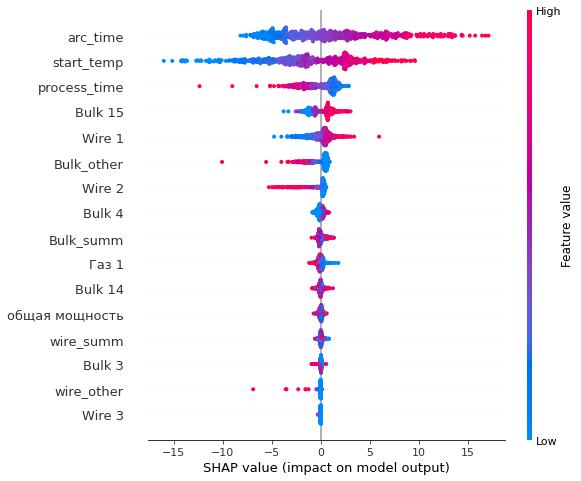

In [143]:
shap.initjs()
explainer = shap.Explainer(best_model, features_test)
shap_values = explainer(features_test)
shap.plots.beeswarm(shap_values, max_display = 22)

**Вывод**  
Наиболее важным признаком как ни странно оказалось суммарное время нагрева электродом, тут все более чем логично - чем дольше производилось нагревание, тем сильнее это влияло на конечную температуру.  
  
Вторым по важности является начальная температура - партии с низкой начальной температурой, почти не влияют на целевой признак, в то время как высокая начальная температура - задает основной тренд для Конечной. Это может означать что чем горячее к нам поступает с предыдущего процесса сплав, тем выше будет и конечная.  
  
Следом идет продолжительность производтсвенного процесса, как видим основная масса объектов расположена в середине графика, при этом высокие  и низкие значения признаков довольно сильно перемешаны, однако общая тенденция видна - чем ниже продолжительность процесса, тем сильнее она влияет на конечную температуру.
  
Следом уж в меньшей степени но идут добавки Bulk 15 и wire 1. Их поведение очень схожи между собой а именно- чем больший объем засыпают тем более высокое значение целевого признака мы получаем.

  
Для заказчика это означает что если он хочет снизить конечную температуру, то в первую очередь ему необходимо : 
1) Уменьшить продолжительность нагрева электродами
2) изучить предшествующий описанному в задаче процесс, т.к. от того какой температур поступает к нам ковш сильнее всего зависит конечная температура.И Снизить начальную температуру.  
3) Увеличить продолжительность производтсвенного процесса (Сплав будет остывать естественным способом).    
4) Отрегулировать объем основных добавок а именно wire 1 и bulk 15 

## **Общий вывод**

Все пункты первоначального плана были выполнены:  

***Изучение и предобрабока данных***  
Вместе с описанием задачи, было получено 7 датасетов с исходной информацией.
Эти данные были изучены, и обработанны. В результате предобработки были сформированы 5 датафреймов, в которых объектом является номер партии "key".  

Количество полученных объектов:  
3214 в данных по электродам  
3129 в данных по сыпучим добавкам  
3081 в данных по проволочным добавкам  
3239 в данных по объему газа  
2475 в данных по температуре  
Общее количество признаков составило 19 шт, из которых 1 целевой:  

1) Целевой признак - finish_temp - Конечная температура.  
2) Остальные признаки :  
- Активная мощность  
- Реактивная мощность  
- arc_time - Продолжительность нагрева  
- Bulk 3 - сыпучая добавка 3  
- Bulk 4 - сыпучая добавка 4  
- Bulk 12 - сыпучая добавка 12  
- Bulk 14 - сыпучая добавка 14  
- Bulk 15 - сыпучая добавка 15  
- Bulk_other - содержит общий объем сыпучих добавок частота использования которых ниже 20%  
- Bulk_summ - общий объем сыпучих добавок  
- Wire 1 - проволочная добавка 1  
- Wire 2 - проволочная добавка 2  
- Wire 3 - проволочная добавка 3  
- wire_other - содержит общий объем проволочных добавок частота использования которых ниже 2%  
- wire_summ - общий объем сыпучих добавок  
- Газ 1 - объем использованого газа  
- start_temp - начальная температура сплава 
- process_time - общая продолжительность процесса.  
  
Было выявлено что все признаки, кроме Bulk 15 имеют нормальное распределение.  
Во время исследования не было выявлено дубликатов.
Были обнаружены и удалены единичные аномалии.
Пропуски в данных были либо удалены, либо заполнены нулями на основании временных меток.

После чего данные данные были объединены в общую таблицу таким образом чтобы  в нее вошли все партии, у которых все признаки были в наличии.  
  
Далее была проведена проверка на мультиколлениарность признаков, В результате были вывлены признаки с чрезмерной зависимостью: 
1) Активная и Рекативная мощности. По формуле была рассчитана общая мощность и добавлена как признак. А Активная и Реактивная были удалены.  
2) Общий объем сыпучих добавок и сыпучая добавка номер 12. Поскольку добавка 12 учтена в общем объеме, то этот признак был удален.  

В результате получили датафрейм состоящий из 2327 объектов и 16-ти признаков,один из которых - целевой.

Итоговый список признаков выглядит так :
1) Целевой признак - finish_temp - Конечная температура.  
2) Остальные признаки :  
- общая мощность  
- arc_time - Продолжительность нагрева  
- Bulk 3 - сыпучая добавка 3  
- Bulk 4 - сыпучая добавка 4  
- Bulk 14 - сыпучая добавка 14  
- Bulk 15 - сыпучая добавка 15  
- Bulk_other - содержит общий объем сыпучих добавок частота использования которых ниже 20%  
- Bulk_summ - общий объем сыпучих добавок  
- Wire 1 - проволочная добавка 1  
- Wire 2 - проволочная добавка 2  
- Wire 3 - проволочная добавка 3  
- wire_other - содержит общий объем проволочных добавок частота использования которых ниже 2%  
- wire_summ - общий объем сыпучих добавок  
- Газ 1 - объем использованого газа  
- start_temp - начальная температура сплава 
- process_time - общая продолжительность процесса.
  
***Подготовка и построение модели***  
Датафрейм был разделен на обучающую и тестовую выборки. Размер тестовой выборки составил 25%.  

Признаки обучающей выборки стандартизировали, и сохранили в отдельный dataframe для сравнения с работой модели без стандартизации. Как показал результат - Стандартизация на данных этой задачи сильно ухудшает точность прогноза. Скорее всего это связано с большим количеством нулевых значений.  
  
Лучшую модель выбирали из 4-х враиантов :  
1) Линейная регрессия   
2) Градиентный бустинг  
3) Случайный лес  
4) Catboost  
 
С помощью автоматической модели GridsearchCV подобрали оптимальные гиперпараметры для каждой модели, обучили их, и оптимизировали метрику Среднюю абсолютную ошибку(MAE) с помощью кросс-валидации, результатом которой стал выбор модели RandomForestRegressor(max_depth=9, n_estimators=90, random_state=80523) как лучшей из 4-х, которая на тестовой выборке показала MAE в размере 5,932 градуса(на стандартизированных признаках).

***Проверка значимости признаков***  
Так же была проведена проверка значимости признаков, итоги которых описаны ниже :

Наиболее важным признаком как ни странно оказалось суммарное время нагрева электродом, тут все более чем логично - чем дольше производилось нагревание, тем сильнее это влияло на конечную температуру.  
  
Вторым по важности является начальная температура - партии с низкой начальной температурой, почти не влияют на целевой признак, в то время как высокая начальная температура - задает основной тренд для Конечной. Это может означать что чем горячее к нам поступает с предыдущего процесса сплав, тем выше будет и конечная.  
  
Следом идет продолжительность производтсвенного процесса, как видим основная масса объектов расположена в середине графика, при этом высокие  и низкие значения признаков довольно сильно перемешаны, однако общая тенденция видна - чем ниже продолжительность процесса, тем сильнее она влияет на конечную температуру.
  
Следом уж в меньшей степени но идут добавки Bulk 15 и wire 1. Их поведение очень схожи между собой а именно- чем больший объем засыпают тем более высокое значение целевого признака мы получаем.

  
Для заказчика это означает что если он хочет снизить конечную температуру, то в первую очередь ему необходимо : 
1) Уменьшить продолжительность нагрева электродами  
2) изучить предшествующий описанному в задаче процесс, т.к. от того какой температур поступает к нам ковш сильнее всего зависит конечная температура.И Снизить начальную температуру.  
3) Увеличить продолжительность производтсвенного процесса (Сплав будет остывать естественным способом).    
4) Отрегулировать объем основных добавок а именно wire 1 и bulk 15 


***Рекомендацции по улучшению модели***  
На мой взгляд метрика MAE 5.932 удовлетвроительная. тем не менее для еще большей точности можно более глубоко поработать с выбросами, и еще я бы посмотрел как себя поведет метрика, при удалении из данных признаков, которые практически не влияют на таргет( например Bulk 3 и другие подобные), т.е. устранил бы шум.
еще мне кажетяс что увеличение размера выборки тоже может сыграть положительно. возможно стоит собрать побольше данных.